<a href="https://colab.research.google.com/github/sameersundrani/CS230_FinalProject_Covid19Inaccuracies/blob/main/Final%20Code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# A Deep Learning Approach to Quantifying COVID 19 Reporting Inaccuracies in the US
## CS230 Final Project 2021
### Sameer Sundrani and Amy Zhang
### TA Mentor: Ruta & Ayush

# Imported Libraries & gDrive Mounting

In [2]:
import numpy as np
import pandas as pd
import time
import seaborn as sns
#TO DO: IMPORT ALL FILES HERE
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers

print(tf.__version__)
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
from sklearn.model_selection import train_test_split, RepeatedStratifiedKFold, cross_val_score, GridSearchCV, StratifiedKFold, RandomizedSearchCV
from sklearn.metrics import explained_variance_score, mean_absolute_error #for linear regression evaluation
from sklearn import linear_model
from sklearn import preprocessing
#END TO DO
from google.colab import drive

2.7.0


In [3]:
drive.mount('/content/drive', force_remount=True)
FOLDERNAME = '/content/drive/MyDrive/CS230_FINAL_PROJECT'


Mounted at /content/drive


# Data Processing & Dataset Preparation

In [ ]:
travel_data_raw = pd.read_csv(FOLDERNAME + "/Trips_by_Distance.csv")
covid_counts_raw = pd.read_csv(FOLDERNAME + "/us-counties.csv")

KeyboardInterrupt: ignored

In [ ]:
#travel_data_raw.head()
travel_counties = travel_data_raw.loc[travel_data_raw['Level'] == "County"]
travel_counties_final = travel_counties[['Date', 'State Postal Code', 'County Name', 'Number of Trips', 'Number of Trips <1', 'Number of Trips 1-3', 'Number of Trips 3-5', 'Number of Trips 5-10', 'Number of Trips 10-25', 'Number of Trips 25-50', 'Number of Trips 50-100', 'Number of Trips 100-250', 'Number of Trips 250-500', 'Number of Trips >=500']]
travel_counties_final['County Name'] = travel_counties_final['County Name'].apply(lambda x: x.split(" ")[0])
travel_counties_final = travel_counties_final.rename(columns={"Date": "date", "State Postal Code": "state", "County Name": "county"})
travel_counties_final.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


,date,state,county,Number of Trips,Number of Trips <1,Number of Trips 1-3,Number of Trips 3-5,Number of Trips 5-10,Number of Trips 10-25,Number of Trips 25-50,Number of Trips 50-100,Number of Trips 100-250,Number of Trips 250-500,Number of Trips >=500
21061,2021/06/06,WY,Weston,22471.0,4160.0,2601.0,948.0,1558.0,5723.0,2202.0,3930.0,1160.0,166.0,23.0
22762,2021/06/06,AR,Bradley,25022.0,3411.0,4145.0,5901.0,4321.0,3343.0,1793.0,1383.0,690.0,35.0,0.0
22763,2021/06/06,AR,Calhoun,17543.0,2166.0,2168.0,3195.0,3600.0,4277.0,1141.0,530.0,425.0,41.0,0.0
22764,2021/06/06,AR,Carroll,77047.0,14712.0,16029.0,11434.0,13170.0,14712.0,4272.0,1227.0,1323.0,132.0,36.0
22765,2021/06/06,AR,Chicot,31550.0,9483.0,6752.0,4547.0,3929.0,3857.0,1380.0,580.0,957.0,61.0,4.0


In [ ]:
covid_counts_final = covid_counts_raw[['date', 'county', 'state', 'cases']]
covid_counts_final['date'] = covid_counts_final['date'].apply(lambda x: x.replace('-', '/'))
us_state_to_abbrev = {
    "Alabama": "AL",
    "Alaska": "AK",
    "Arizona": "AZ",
    "Arkansas": "AR",
    "California": "CA",
    "Colorado": "CO",
    "Connecticut": "CT",
    "Delaware": "DE",
    "Florida": "FL",
    "Georgia": "GA",
    "Hawaii": "HI",
    "Idaho": "ID",
    "Illinois": "IL",
    "Indiana": "IN",
    "Iowa": "IA",
    "Kansas": "KS",
    "Kentucky": "KY",
    "Louisiana": "LA",
    "Maine": "ME",
    "Maryland": "MD",
    "Massachusetts": "MA",
    "Michigan": "MI",
    "Minnesota": "MN",
    "Mississippi": "MS",
    "Missouri": "MO",
    "Montana": "MT",
    "Nebraska": "NE",
    "Nevada": "NV",
    "New Hampshire": "NH",
    "New Jersey": "NJ",
    "New Mexico": "NM",
    "New York": "NY",
    "North Carolina": "NC",
    "North Dakota": "ND",
    "Ohio": "OH",
    "Oklahoma": "OK",
    "Oregon": "OR",
    "Pennsylvania": "PA",
    "Rhode Island": "RI",
    "South Carolina": "SC",
    "South Dakota": "SD",
    "Tennessee": "TN",
    "Texas": "TX",
    "Utah": "UT",
    "Vermont": "VT",
    "Virginia": "VA",
    "Washington": "WA",
    "West Virginia": "WV",
    "Wisconsin": "WI",
    "Wyoming": "WY",
    "District of Columbia": "DC",
    "American Samoa": "AS",
    "Guam": "GU",
    "Northern Mariana Islands": "MP",
    "Puerto Rico": "PR",
    "United States Minor Outlying Islands": "UM",
    "Virgin Islands": "VI",
}
covid_counts_final['state'] = covid_counts_final['state'].apply(lambda x: us_state_to_abbrev[x])
covid_counts_final.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:62: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,date,county,state,cases
0,2020/01/21,Snohomish,WA,1
1,2020/01/22,Snohomish,WA,1
2,2020/01/23,Snohomish,WA,1
3,2020/01/24,Cook,IL,1
4,2020/01/24,Snohomish,WA,1


In [ ]:
final_data = pd.merge(covid_counts_final, travel_counties_final)
final_data.head()

,date,county,state,cases,Number of Trips,Number of Trips <1,Number of Trips 1-3,Number of Trips 3-5,Number of Trips 5-10,Number of Trips 10-25,Number of Trips 25-50,Number of Trips 50-100,Number of Trips 100-250,Number of Trips 250-500,Number of Trips >=500
0,2020/01/21,Snohomish,WA,1,2944078.0,762651.0,726576.0,308236.0,417195.0,540130.0,159563.0,20442.0,4391.0,1152.0,3742.0
1,2020/01/22,Snohomish,WA,1,3006800.0,784271.0,732019.0,311760.0,432308.0,551873.0,165546.0,21241.0,3654.0,1031.0,3097.0
2,2020/01/23,Snohomish,WA,1,2952207.0,782244.0,724152.0,305706.0,405046.0,535931.0,167202.0,22195.0,5095.0,1135.0,3501.0
3,2020/01/24,Cook,IL,1,21307310.0,6266951.0,5185299.0,2574174.0,3260629.0,2988478.0,774147.0,130659.0,86057.0,24356.0,16560.0
4,2020/01/24,Snohomish,WA,1,3167046.0,857787.0,779656.0,334594.0,448890.0,550137.0,160682.0,23484.0,6369.0,1343.0,4104.0


In [ ]:
final_data.to_csv(FOLDERNAME+'/final_data.csv')

In [ ]:
print("Number of Total Inputs: ", len(final_data))
# print("Confirmed (number should be the same): ",np.sum(final_data.groupby('county').size().to_list()))
print("Number of Total Counties: " ,len(final_data.groupby('county').size().to_list()))

Number of Total Inputs:  1609217
Number of Total Counties:  1620


# Initial Data Visualization - Number Recorded Days per County (Initial Distribution)

Text(0, 0.5, 'Number of Recorded Days')

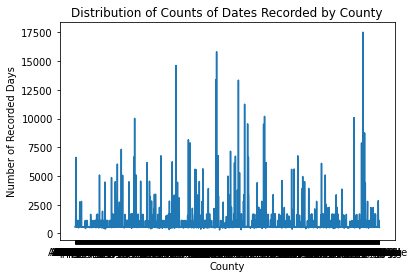

In [ ]:
cases_by_county_df = final_data.groupby('county').size()
plt.plot(cases_by_county_df)
plt.title('Distribution of Counts of Dates Recorded by County')
plt.xlabel('County')
plt.ylabel('Number of Recorded Days')

# Initial Modeling (Begin **Here** if Data is Preprocessed)

In [126]:
final_data_old = pd.read_csv(FOLDERNAME+'/final_data.csv').iloc[0:, 1:]
final_data_old = final_data_old.dropna()
final_data_old

,date,county,state,cases,Number of Trips,Number of Trips <1,Number of Trips 1-3,Number of Trips 3-5,Number of Trips 5-10,Number of Trips 10-25,Number of Trips 25-50,Number of Trips 50-100,Number of Trips 100-250,Number of Trips 250-500,Number of Trips >=500
0,2020/01/21,Snohomish,WA,1,2944078.0,762651.0,726576.0,308236.0,417195.0,540130.0,159563.0,20442.0,4391.0,1152.0,3742.0
1,2020/01/22,Snohomish,WA,1,3006800.0,784271.0,732019.0,311760.0,432308.0,551873.0,165546.0,21241.0,3654.0,1031.0,3097.0
2,2020/01/23,Snohomish,WA,1,2952207.0,782244.0,724152.0,305706.0,405046.0,535931.0,167202.0,22195.0,5095.0,1135.0,3501.0
3,2020/01/24,Cook,IL,1,21307310.0,6266951.0,5185299.0,2574174.0,3260629.0,2988478.0,774147.0,130659.0,86057.0,24356.0,16560.0
4,2020/01/24,Snohomish,WA,1,3167046.0,857787.0,779656.0,334594.0,448890.0,550137.0,160682.0,23484.0,6369.0,1343.0,4104.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1609212,2021/10/09,Sweetwater,WY,7146,150383.0,44724.0,42942.0,16840.0,10339.0,23587.0,4235.0,4609.0,2770.0,304.0,33.0
1609213,2021/10/09,Teton,WY,4984,73825.0,11969.0,14734.0,10625.0,17087.0,9835.0,5043.0,3359.0,721.0,197.0,255.0
1609214,2021/10/09,Uinta,WY,3660,67281.0,16554.0,21920.0,8434.0,5411.0,6250.0,2962.0,4187.0,1396.0,132.0,35.0
1609215,2021/10/09,Washakie,WY,1485,28591.0,11229.0,6922.0,3320.0,2123.0,2725.0,1577.0,400.0,266.0,22.0,7.0


In [9]:
final_data_old.columns

Index(['date', 'county', 'state', 'cases', 'Number of Trips',
       'Number of Trips <1', 'Number of Trips 1-3', 'Number of Trips 3-5',
       'Number of Trips 5-10', 'Number of Trips 10-25',
       'Number of Trips 25-50', 'Number of Trips 50-100',
       'Number of Trips 100-250', 'Number of Trips 250-500',
       'Number of Trips >=500'],
      dtype='object')

In [10]:
#Quick Check for NA/NaN in data
final_data_old.isnull().any()

date                       False
county                     False
state                      False
cases                      False
Number of Trips            False
Number of Trips <1         False
Number of Trips 1-3        False
Number of Trips 3-5        False
Number of Trips 5-10       False
Number of Trips 10-25      False
Number of Trips 25-50      False
Number of Trips 50-100     False
Number of Trips 100-250    False
Number of Trips 250-500    False
Number of Trips >=500      False
dtype: bool

In [11]:
#Check Dates: 
dates_ordered = final_data_old.groupby('date')
dates_ordered.head()

,date,county,state,cases,Number of Trips,Number of Trips <1,Number of Trips 1-3,Number of Trips 3-5,Number of Trips 5-10,Number of Trips 10-25,Number of Trips 25-50,Number of Trips 50-100,Number of Trips 100-250,Number of Trips 250-500,Number of Trips >=500
0,2020/01/21,Snohomish,WA,1,2944078.0,762651.0,726576.0,308236.0,417195.0,540130.0,159563.0,20442.0,4391.0,1152.0,3742.0
1,2020/01/22,Snohomish,WA,1,3006800.0,784271.0,732019.0,311760.0,432308.0,551873.0,165546.0,21241.0,3654.0,1031.0,3097.0
2,2020/01/23,Snohomish,WA,1,2952207.0,782244.0,724152.0,305706.0,405046.0,535931.0,167202.0,22195.0,5095.0,1135.0,3501.0
3,2020/01/24,Cook,IL,1,21307310.0,6266951.0,5185299.0,2574174.0,3260629.0,2988478.0,774147.0,130659.0,86057.0,24356.0,16560.0
4,2020/01/24,Snohomish,WA,1,3167046.0,857787.0,779656.0,334594.0,448890.0,550137.0,160682.0,23484.0,6369.0,1343.0,4104.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1606319,2021/10/09,Autauga,AL,9843,157429.0,35283.0,35381.0,16280.0,19496.0,36916.0,7960.0,3687.0,2096.0,285.0,45.0
1606320,2021/10/09,Baldwin,AL,36870,602903.0,125819.0,147443.0,75865.0,97680.0,105601.0,35869.0,8170.0,4230.0,1730.0,496.0
1606321,2021/10/09,Barbour,AL,3545,82550.0,18235.0,16826.0,10033.0,18291.0,10029.0,6079.0,2213.0,687.0,147.0,10.0
1606322,2021/10/09,Bibb,AL,4192,68339.0,8012.0,16078.0,7679.0,18108.0,9321.0,6373.0,2150.0,510.0,96.0,12.0


In [12]:
print("To Confirm: Number of Total Inputs: (should <= 1609217 (b/c of some previous null values)) ", len(final_data_old))

To Confirm: Number of Total Inputs: (should <= 1609217 (b/c of some previous null values))  1602900


#Adding more economic indicators to dataset (https://www.ers.usda.gov/data-products/county-level-data-sets/download-data)
Civilian_labor_force_2020 = 	Civilian labor force annual average, 2020
Employed_2020	= Number employed annual average, 2020
Unemployed_2020	= Number unemployed annual average, 2020
Unemployment_rate_2020	= Unemployment rate, 2020
Median_Household_Income_2019	= Estimate of median household Income, 2019
Med_HH_Income_Percent_of_State_Total_2019	= County household median income as a percent of the State total median household income, 2019

POVALL_2019	= Estimate of people of all ages in poverty 2019 //
POV017_2019	= Estimate of people age 0-17 in poverty 2019

In [127]:
unemployment = pd.read_csv(FOLDERNAME+'/Unemployment.csv')
unemployment = unemployment[unemployment["county"].str.contains(",")==True]
unemployment['county'] = unemployment['county'].apply(lambda x: x.split(" County")[0])
final_unemployment = pd.merge(final_data_old, unemployment)

poverty = pd.read_csv(FOLDERNAME+'/PovertyEstimates-3.csv')
poverty = poverty[poverty["county"].str.contains("County")==True]
poverty['county'] = poverty['county'].apply(lambda x: x.split(" County")[0])
final_data = pd.merge(final_unemployment, poverty)
final_data['Civilian_labor_force_2020'] = final_data['Civilian_labor_force_2020'].apply(lambda x: int(x.replace(',', '')))
final_data['Employed_2020'] = final_data['Employed_2020'].apply(lambda x: int(x.replace(',', '')))
final_data['Unemployed_2020'] = final_data['Unemployed_2020'].apply(lambda x: int(x.replace(',', '')))
final_data['Median_Household_Income_2019'] = final_data['Median_Household_Income_2019'].apply(lambda x: int(x.replace(',', '')))
final_data['POVALL_2019'] = final_data['POVALL_2019'].apply(lambda x: int(x.replace(',', '')))
final_data['POV017_2019'] = final_data['POV017_2019'].apply(lambda x: int(x.replace(',', '')))

final_data = final_data.dropna()

final_data

,date,county,state,cases,Number of Trips,Number of Trips <1,Number of Trips 1-3,Number of Trips 3-5,Number of Trips 5-10,Number of Trips 10-25,Number of Trips 25-50,Number of Trips 50-100,Number of Trips 100-250,Number of Trips 250-500,Number of Trips >=500,Civilian_labor_force_2020,Employed_2020,Unemployed_2020,Unemployment_rate_2020,Median_Household_Income_2019,Med_HH_Income_Percent_of_State_Total_2019,POVALL_2019,POV017_2019
0,2020/01/21,Snohomish,WA,1,2944078.0,762651.0,726576.0,308236.0,417195.0,540130.0,159563.0,20442.0,4391.0,1152.0,3742.0,441156,403863,37293,8.5,89119,113.3,56935,14611
1,2020/01/22,Snohomish,WA,1,3006800.0,784271.0,732019.0,311760.0,432308.0,551873.0,165546.0,21241.0,3654.0,1031.0,3097.0,441156,403863,37293,8.5,89119,113.3,56935,14611
2,2020/01/23,Snohomish,WA,1,2952207.0,782244.0,724152.0,305706.0,405046.0,535931.0,167202.0,22195.0,5095.0,1135.0,3501.0,441156,403863,37293,8.5,89119,113.3,56935,14611
3,2020/01/24,Snohomish,WA,1,3167046.0,857787.0,779656.0,334594.0,448890.0,550137.0,160682.0,23484.0,6369.0,1343.0,4104.0,441156,403863,37293,8.5,89119,113.3,56935,14611
4,2020/01/25,Snohomish,WA,1,2889757.0,746396.0,753479.0,316316.0,428858.0,454511.0,151277.0,28052.0,5976.0,1415.0,3477.0,441156,403863,37293,8.5,89119,113.3,56935,14611
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1573389,2021/10/05,Loving,TX,8,400.0,114.0,74.0,50.0,30.0,54.0,55.0,16.0,0.0,3.0,4.0,289,284,5,1.7,88487,138.2,12,5
1573390,2021/10/06,Loving,TX,8,344.0,93.0,88.0,0.0,0.0,21.0,98.0,26.0,10.0,4.0,4.0,289,284,5,1.7,88487,138.2,12,5
1573391,2021/10/07,Loving,TX,8,440.0,59.0,51.0,7.0,110.0,74.0,106.0,8.0,15.0,8.0,2.0,289,284,5,1.7,88487,138.2,12,5
1573392,2021/10/08,Loving,TX,8,474.0,54.0,147.0,18.0,52.0,107.0,74.0,9.0,5.0,5.0,3.0,289,284,5,1.7,88487,138.2,12,5


In [14]:
# normalize travel data portion of final_data to have zero mean and unit variance to optimize learning
scaler = preprocessing.StandardScaler().fit(final_data.iloc[:, 4:])
final_data.iloc[:, 4:] =  scaler.transform(final_data.iloc[:, 4:])
final_data.head()

,date,county,state,cases,Number of Trips,Number of Trips <1,Number of Trips 1-3,Number of Trips 3-5,Number of Trips 5-10,Number of Trips 10-25,Number of Trips 25-50,Number of Trips 50-100,Number of Trips 100-250,Number of Trips 250-500,Number of Trips >=500,Civilian_labor_force_2020,Employed_2020,Unemployed_2020,Unemployment_rate_2020,Median_Household_Income_2019,Med_HH_Income_Percent_of_State_Total_2019,POVALL_2019,POV017_2019
0,2020/01/21,Snohomish,WA,1,2.962613,2.669803,3.044484,2.552364,2.748254,3.817980,3.745130,1.233945,0.300283,0.405599,2.680879,2.79802,2.803181,2.665848,0.808018,2.37366,1.214299,1.29662,0.964628
1,2020/01/22,Snohomish,WA,1,3.033592,2.754920,3.070089,2.585804,2.861203,3.909076,3.901446,1.301557,0.177785,0.327531,2.179544,2.79802,2.803181,2.665848,0.808018,2.37366,1.214299,1.29662,0.964628
2,2020/01/23,Snohomish,WA,1,2.971812,2.746940,3.033081,2.528357,2.657458,3.785406,3.944712,1.382284,0.417295,0.394631,2.493559,2.79802,2.803181,2.665848,0.808018,2.37366,1.214299,1.29662,0.964628
3,2020/01/24,Snohomish,WA,1,3.214932,3.044352,3.294189,2.802480,2.985130,3.895609,3.774366,1.491360,0.629048,0.528831,2.962249,2.79802,2.803181,2.665848,0.808018,2.37366,1.214299,1.29662,0.964628
4,2020/01/25,Snohomish,WA,1,2.901142,2.605807,3.171044,2.629037,2.835419,3.153793,3.528644,1.877904,0.563727,0.575285,2.474904,2.79802,2.803181,2.665848,0.808018,2.37366,1.214299,1.29662,0.964628


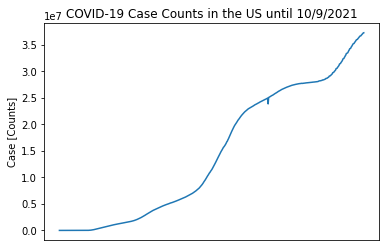

In [15]:
# See cases over the entire dataset, grouped by day
cases = dates_ordered[['date', 'cases']].sum('cases')
frame1 = plt.gca()
plt.plot(cases)
plt.ylabel('Case [Counts]')
frame1.axes.get_xaxis().set_visible(False)
plt.title('COVID-19 Case Counts in the US until 10/9/2021')
plt.savefig(FOLDERNAME+'case_counts', bbox_inches='tight')
# dates_ordered[['date', 'cases']].sum('cases').plot(title='Cases over Time', ylabel='Log Cases')

#Train/Test Split by Time (not used)

In [120]:
# shuff = final_data.sample(frac=1)
# X = shuff.iloc[:,4:] #if wanted to shuffle data before splits
time_split_all_data = final_data[['cases', 'Number of Trips <1',	'Number of Trips 1-3',	'Number of Trips 3-5',	'Number of Trips 5-10',	'Number of Trips 10-25',	'Number of Trips 25-50',	'Number of Trips 50-100',	'Number of Trips 100-250', 'Number of Trips 250-500',	'Number of Trips >=500']].copy() #if we want to just use split by time
#min_max_scaler = preprocessing.MinMaxScaler()
#time_split_all_data[['Number of Trips <1',	'Number of Trips 1-3',	'Number of Trips 3-5',	'Number of Trips 5-10',	'Number of Trips 10-25',	'Number of Trips 25-50',	'Number of Trips 50-100',	'Number of Trips 100-250', 'Number of Trips 250-500',	'Number of Trips >=500']] = min_max_scaler.fit_transform(time_split_all_data[['Number of Trips <1',	'Number of Trips 1-3',	'Number of Trips 3-5',	'Number of Trips 5-10',	'Number of Trips 10-25',	'Number of Trips 25-50',	'Number of Trips 50-100',	'Number of Trips 100-250', 'Number of Trips 250-500',	'Number of Trips >=500']])

xy_train = time_split_all_data.iloc[160291:, :] #train on later part of data
X_train = xy_train.iloc[:, 1:]
y_train = xy_train['cases']

xy_val_test = time_split_all_data.iloc[0:160290, :] #val and test on beginning of data
X_val_test = xy_val_test.iloc[:, 1:]
y_val_test = xy_val_test['cases']

X_val, X_test, y_val, y_test = train_test_split(X_val_test, y_val_test, test_size=0.50)

In [ ]:
print("Train Set Dimensions : ", X_train.shape)
print("Train Labels Dimensions : ", y_train.shape)
print("Val Set Dimensions : ", X_val.shape)
print("Val Labels Dimensions : ", y_val.shape)
print("Test Set Dimensions : ", X_test.shape)
print("Test Labels Dimensions : ", y_test.shape)

Train Set Dimensions :  (1442609, 10)
Train Labels Dimensions :  (1442609,)
Val Set Dimensions :  (80145, 10)
Val Labels Dimensions :  (80145,)
Test Set Dimensions :  (80145, 10)
Test Labels Dimensions :  (80145,)


In [121]:
X_train.head()

,Number of Trips <1,Number of Trips 1-3,Number of Trips 3-5,Number of Trips 5-10,Number of Trips 10-25,Number of Trips 25-50,Number of Trips 50-100,Number of Trips 100-250,Number of Trips 250-500,Number of Trips >=500
160291,615012.0,540191.0,222455.0,290306.0,296373.0,91992.0,21437.0,25866.0,8542.0,4633.0
160292,675989.0,540444.0,247302.0,302444.0,278856.0,83858.0,26486.0,28021.0,6729.0,4425.0
160293,725978.0,644470.0,286281.0,287946.0,259387.0,73488.0,13439.0,17078.0,5290.0,5913.0
160294,646280.0,592482.0,231018.0,254838.0,208992.0,63641.0,15755.0,15342.0,5455.0,3414.0
160295,725121.0,586365.0,271811.0,308766.0,347259.0,106636.0,28997.0,18415.0,4901.0,6510.0


In [ ]:
#Double check that we have no null/NA values
X_train.isnull().any()

Number of Trips <1         False
Number of Trips 1-3        False
Number of Trips 3-5        False
Number of Trips 5-10       False
Number of Trips 10-25      False
Number of Trips 25-50      False
Number of Trips 50-100     False
Number of Trips 100-250    False
Number of Trips 250-500    False
Number of Trips >=500      False
dtype: bool

Text(0, 0.5, 'Case Count')

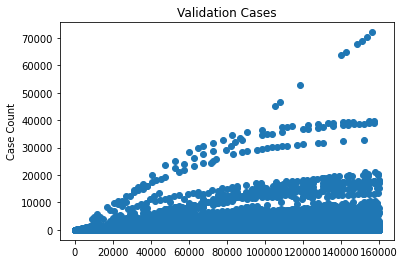

In [ ]:
plt.scatter(X_val.index, y_val, marker='o')
plt.title('Validation Cases')
plt.ylabel('Case Count')

Text(0, 0.5, 'Case Count')

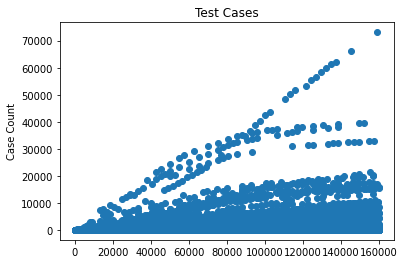

In [ ]:
plt.scatter(X_test.index, y_test, marker='o')
plt.title('Test Cases')
plt.ylabel('Case Count')

Text(0, 0.5, 'Case Count')

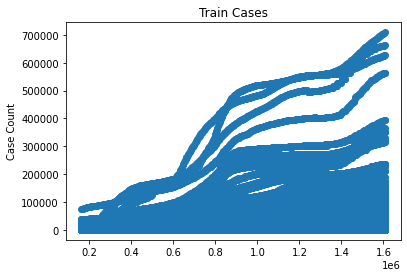

In [ ]:
plt.scatter(X_train.index, y_train, marker='o')
plt.title('Train Cases')
plt.ylabel('Case Count')

## Lasso Regression (https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LassoCV.html#sklearn.linear_model.LassoCV) (L1 Regression)

In [ ]:
print("STARTING MODEL FITTING")
start=time.time()
reg_lasso = linear_model.LassoCV(random_state=1, max_iter=100000).fit(X_train, y_train)
stop=time.time()
print("MODEL FITTING FINISHED -- Total Time = ", stop-start, ' ms')

STARTING MODEL FITTING
MODEL FITTING FINISHED -- Total Time =  26.065693855285645  ms


In [ ]:
reg_lasso_params = reg_lasso.get_params()
print(reg_lasso_params)

{'alphas': None, 'copy_X': True, 'cv': None, 'eps': 0.001, 'fit_intercept': True, 'max_iter': 100000, 'n_alphas': 100, 'n_jobs': None, 'normalize': False, 'positive': False, 'precompute': 'auto', 'random_state': 1, 'selection': 'cyclic', 'tol': 0.0001, 'verbose': False}


In [ ]:
print(reg_lasso.coef_)
print(reg_lasso.intercept_)

[ 30731.34551709 -29932.36679242   9016.94197029   8592.66086112
    -56.31770971   1564.66479952   -262.87117501    243.9029377
    337.65074779   -741.06857771]
6382.091728219687


In [ ]:
y_pred = reg_lasso.predict(X_val)
exp_var_score = explained_variance_score(y_val, y_pred)
print("Score = ", exp_var_score) #Note that 1.0 is the best

Score =  -165.08358390029352


Text(0, 0.5, 'Predicted')

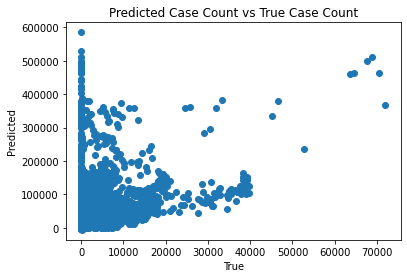

In [ ]:
plt.scatter(y_val, y_pred) #Should be a straight line
plt.title('Predicted Case Count vs True Case Count')
plt.xlabel('True')
plt.ylabel('Predicted')

##Ridge Regression (https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Ridge.html) (L2 Regression)

In [ ]:
print("STARTING MODEL FITTING")
start=time.time()
reg_ridge = linear_model.RidgeCV().fit(X_train, y_train)
stop=time.time()
print("MODEL FITTING FINISHED -- Total Time = ", stop-start, ' ms')

STARTING MODEL FITTING
MODEL FITTING FINISHED -- Total Time =  1.1318812370300293  ms


In [ ]:
reg_ridge_params = reg_ridge.get_params()
print(reg_ridge_params)

{'alphas': array([ 0.1,  1. , 10. ]), 'cv': None, 'fit_intercept': True, 'gcv_mode': None, 'normalize': False, 'scoring': None, 'store_cv_values': False}


In [ ]:
print(reg_ridge.coef_)
print(reg_ridge.intercept_)

[ 32418.1196839  -36376.87840974  13519.37703388  10230.49157886
  -2759.63209134   3216.52025195   -701.71965055    496.17427559
    238.55117549   -794.33190875]
6366.502092570237


In [ ]:
y_pred = reg_ridge.predict(X_val)
exp_var_score = explained_variance_score(y_val, y_pred)
print("Score = ", exp_var_score) #Note that 1.0 is the best

Score =  -161.2136648356446


Text(0, 0.5, 'Predicted')

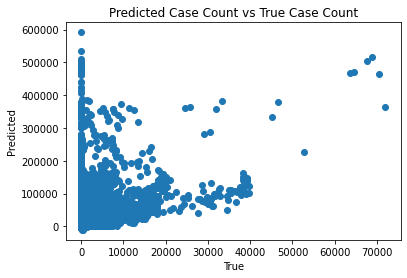

In [ ]:
plt.scatter(y_val, y_pred) #Should be a straight line
plt.title('Predicted Case Count vs True Case Count')
plt.xlabel('True')
plt.ylabel('Predicted')

# Train/Test Split by State (proxy for testing quality) (https://www.nytimes.com/interactive/2020/us/coronavirus-testing.html)

In [128]:
#final_data.head()
state_split_all_data = final_data[['state', 'cases', 'Number of Trips <1',	'Number of Trips 1-3',	'Number of Trips 3-5',	'Number of Trips 5-10',	'Number of Trips 10-25',	'Number of Trips 25-50',	'Number of Trips 50-100',	'Number of Trips 100-250', 'Number of Trips 250-500',	'Number of Trips >=500', 'Civilian_labor_force_2020',	'Employed_2020',	'Unemployed_2020',	'Unemployment_rate_2020',	'Median_Household_Income_2019',	'Med_HH_Income_Percent_of_State_Total_2019',	'POVALL_2019',	'POV017_2019']].copy()
#First, we normalize using sklearn's MinMaxScaler()
#x2 = X2.values #returns a numpy array
#min_max_scaler = preprocessing.MinMaxScaler()
#state_split_all_data[['Number of Trips <1',	'Number of Trips 1-3',	'Number of Trips 3-5',	'Number of Trips 5-10',	'Number of Trips 10-25',	'Number of Trips 25-50',	'Number of Trips 50-100',	'Number of Trips 100-250', 'Number of Trips 250-500',	'Number of Trips >=500']] = min_max_scaler.fit_transform(state_split_all_data[['Number of Trips <1',	'Number of Trips 1-3',	'Number of Trips 3-5',	'Number of Trips 5-10',	'Number of Trips 10-25',	'Number of Trips 25-50',	'Number of Trips 50-100',	'Number of Trips 100-250', 'Number of Trips 250-500',	'Number of Trips >=500']])
state_split_all_data_normalized = state_split_all_data.sample(frac=1) #shuffle everything

X2 = state_split_all_data_normalized[['state', 'Number of Trips <1',	'Number of Trips 1-3',	'Number of Trips 3-5',	'Number of Trips 5-10',	'Number of Trips 10-25',	'Number of Trips 25-50',	'Number of Trips 50-100',	'Number of Trips 100-250', 'Number of Trips 250-500',	'Number of Trips >=500', 'Civilian_labor_force_2020',	'Employed_2020',	'Unemployed_2020',	'Unemployment_rate_2020',	'Median_Household_Income_2019',	'Med_HH_Income_Percent_of_State_Total_2019',	'POVALL_2019',	'POV017_2019']]
y2 = state_split_all_data_normalized['cases']


In [129]:
X_train2 = X2[X2['state'].isin(['VT', 'ME', 'NY', 'RI', 'MA', 'NH', 'CT', 'HI', 'MI', 'WA', 'MD', 'NJ', 'CA', 'DE', 'VA', 'CO', 'FL', 'IL', 'NC', 'LA', 'NM', 'WV', 'OR', 'SC', 'AK', 'GA', 'OH', 'AR', 'PA', 'MN', 'IN', 'NV', 'NE', 'UT', 'OK', 'KY', 'MS', 'AZ', 'MO', 'TN', 'TX'])]
X_train2 = X_train2.iloc[:, 1:]
y_train2 = y2[X2['state'].isin(['VT', 'ME', 'NY', 'RI', 'MA', 'NH', 'CT', 'HI', 'MI', 'WA', 'MD', 'NJ', 'CA', 'DE', 'VA', 'CO', 'FL', 'IL', 'NC', 'LA', 'NM', 'WV', 'OR', 'SC', 'AK', 'GA', 'OH', 'AR', 'PA', 'MN', 'IN', 'NV', 'NE', 'UT', 'OK', 'KY', 'MS', 'AZ', 'MO', 'TN', 'TX'])]

X_val_test2 = X2[X2['state'].isin(['SD', 'IA', 'WY', 'ID', 'KS', 'AL', 'MT', 'WI'])]
X_val_test2 = X_val_test2.iloc[:, 1:]
y_val_test2 = y2[X2['state'].isin(['SD', 'IA', 'WY', 'ID', 'KS', 'AL', 'MT', 'WI'])]

X_val_states, X_test_states, y_val_states, y_test_states = train_test_split(X_val_test2, y_val_test2, test_size=0.50, random_state=1)
print(X_train2)

         Number of Trips <1  Number of Trips 1-3  ...  POVALL_2019  POV017_2019
1167478             78314.0              80970.0  ...        10052         2363
1153339             21143.0              19137.0  ...         3266         1150
774615              18381.0              14250.0  ...         2176          846
438722              80664.0              98595.0  ...        18444         6404
1433335              2388.0               2088.0  ...          395          139
...                     ...                  ...  ...          ...          ...
1439519              2783.0               5712.0  ...         1067          239
1245049              5972.0               7930.0  ...         1982          642
1116520             24311.0              29968.0  ...         6231         1874
331369               6399.0               7442.0  ...         1271          246
1363657              7460.0               4633.0  ...         2515          948

[1273308 rows x 18 columns]


In [18]:
print("Train Set Dimensions : ", X_train2.shape)
print("Train Labels Dimensions : ", y_train2.shape)
print("Val Set Dimensions : ", X_val_states.shape)
print("Val Labels Dimensions : ", y_val_states.shape)
print("Test Set Dimensions : ", X_test_states.shape)
print("Test Labels Dimensions : ", y_test_states.shape)

Train Set Dimensions :  (1273308, 18)
Train Labels Dimensions :  (1273308,)
Val Set Dimensions :  (136613, 18)
Val Labels Dimensions :  (136613,)
Test Set Dimensions :  (136613, 18)
Test Labels Dimensions :  (136613,)


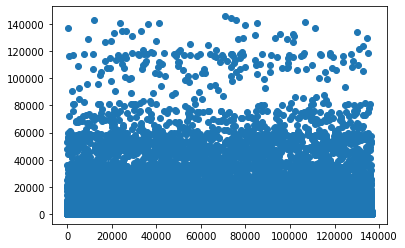

In [42]:
plt.scatter(range(X_test_states.shape[0]), y_test_states)

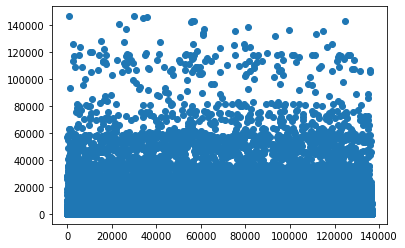

In [43]:
plt.scatter(range(X_val_states.shape[0]), y_val_states)

# Modeling

## Lasso Regression

In [ ]:
print("STARTING MODEL FITTING")
start=time.time()
reg_lasso = linear_model.LassoCV(random_state=1, max_iter=100000).fit(X_train2.iloc[:, 1:], y_train2)
stop=time.time()
print("MODEL FITTING FINISHED -- Total Time = ", stop-start, ' ms')


STARTING MODEL FITTING
MODEL FITTING FINISHED -- Total Time =  31.24094009399414  ms


In [ ]:
y_pred_states_lasso = reg_lasso.predict(X_val_states.iloc[:, 1:])
#exp_var_score = explained_variance_score(y_val_states, y_pred_states)
corr_lasso, _ = pearsonr(y_val_states, y_pred_states_lasso)
print("Pearson Correlation Coefficient = ", corr_lasso) # Note: r = 0.5 - 1.0 means strong positive association
print("Mean Abolsute Error = ", mean_absolute_error(y_pred_states_lasso, y_val_states))
print(reg_lasso.coef_)
print(reg_lasso.intercept_)


Pearson Correlation Coefficient =  0.8272122343904837
Mean Abolsute Error =  2238.494854782451
[-13690.76586286  12249.3398469   25025.60993794      0.
   1578.71487074  -1444.24886148   -617.55825811   -133.45952845
   1261.05386831  -4417.24793177   -194.53858098  -4479.33475599
      0.           -205.47283212   -240.12841582      0.
   1986.85582124]
5466.559448410964


Text(0, 0.5, 'Predicted')

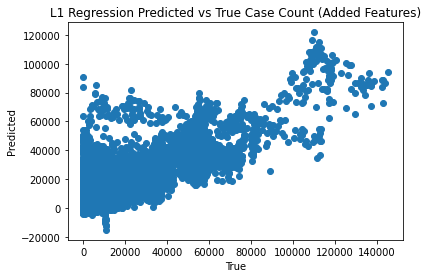

In [ ]:
plt.scatter(y_val_states, y_pred_states_lasso) #Should be a straight line
plt.title('L1 Regression Predicted vs True Case Count (Added Features)')
plt.xlabel('True')
plt.ylabel('Predicted')

## Ridge Regression

In [ ]:
print("STARTING MODEL FITTING")
start=time.time()
reg_ridge = linear_model.RidgeCV().fit(X_train2.iloc[:, 1:], y_train2)
stop=time.time()
print("MODEL FITTING FINISHED -- Total Time = ", stop-start, ' ms')

STARTING MODEL FITTING
MODEL FITTING FINISHED -- Total Time =  1.4053881168365479  ms


In [ ]:
y_pred_states_ridge = reg_ridge.predict(X_val_states.iloc[:, 1:])
#exp_var_score = explained_variance_score(y_val_states, y_pred_states)
corr_ridge, _ = pearsonr(y_val_states, y_pred_states_ridge)
print("Pearson Correlation Coefficient = ", corr_ridge) # Note: r = 0.5 - 1.0 means strong positive association
print("Mean Abolsute Error = ", mean_absolute_error(y_pred_states_ridge, y_val_states))
print(reg_ridge.coef_)
print(reg_ridge.intercept_)

Pearson Correlation Coefficient =  0.8247897737928707
Mean Abolsute Error =  2312.516491736619
[-18154.42911839  16656.5433616   25162.5561952    -601.49805108
   2408.45530565  -1716.51799632   -655.21214459   -342.84566331
   1402.78051772  -2523.75690963  -2291.11319213  -4822.35772019
     33.97165181    -67.1761014    -320.03373558   1104.25755812
   1475.980224  ]
5455.987844004896


Text(0, 0.5, 'Predicted')

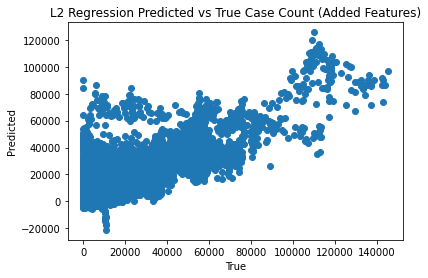

In [ ]:
plt.scatter(y_val_states, y_pred_states_ridge) #Should be a straight line
plt.title('L2 Regression Predicted vs True Case Count (Added Features)')
plt.xlabel('True')
plt.ylabel('Predicted')

##2 Layer Neural Network (Tensorflow)

In [113]:
normalizer = tf.keras.layers.Normalization(axis=-1)

In [115]:
normalizer.adapt(np.array(X_train2)) #removed states for now bc not in number format

In [116]:
def plot_loss(history):
  plt.plot(history.history['loss'], label='loss')
  plt.plot(history.history['val_loss'], label='val_loss')
  plt.xlabel('Epoch')
  plt.ylabel('Error')
  plt.legend()
  plt.grid(False)

In [ ]:
def build_and_compile_model(norm):
  model = keras.Sequential([
      norm,
      layers.Dense(64, activation='relu'),
      layers.Dense(64, activation='relu'),
      layers.Dense(1)
  ])

  model.compile(loss='mean_absolute_error',
                optimizer=tf.keras.optimizers.Adam(0.01))
  return model

In [ ]:
dnn_model1 = build_and_compile_model(normalizer)
dnn_model1.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization_1 (Normalizat  (None, 17)               35        
 ion)                                                            
                                                                 
 dense_3 (Dense)             (None, 64)                1152      
                                                                 
 dense_4 (Dense)             (None, 64)                4160      
                                                                 
 dense_5 (Dense)             (None, 1)                 65        
                                                                 
Total params: 5,412
Trainable params: 5,377
Non-trainable params: 35
_________________________________________________________________


In [ ]:
%%time
history = dnn_model1.fit(
    Xtrain2_tf,
    y_train2,
    validation_split=0.2,
    verbose=1, epochs=100)

Epoch 1/100
31833/31833 [==============================] - 57s 2ms/step - loss: 3821.0046 - val_loss: 3692.2078
Epoch 2/100
31833/31833 [==============================] - 60s 2ms/step - loss: 3508.9600 - val_loss: 3396.5422
Epoch 3/100
31833/31833 [==============================] - 59s 2ms/step - loss: 3386.2632 - val_loss: 3305.8989
Epoch 4/100
31833/31833 [==============================] - 61s 2ms/step - loss: 3312.5479 - val_loss: 3183.9609
Epoch 5/100
31833/31833 [==============================] - 58s 2ms/step - loss: 3258.3513 - val_loss: 3262.1873
Epoch 6/100
31833/31833 [==============================] - 58s 2ms/step - loss: 3211.5334 - val_loss: 3149.9958
Epoch 7/100
31833/31833 [==============================] - 59s 2ms/step - loss: 3170.2717 - val_loss: 3177.8291
Epoch 8/100
31833/31833 [==============================] - 60s 2ms/step - loss: 3125.9902 - val_loss: 3096.8772
Epoch 9/100
31833/31833 [==============================] - 62s 2ms/step - loss: 3092.6230 - val_loss: 30

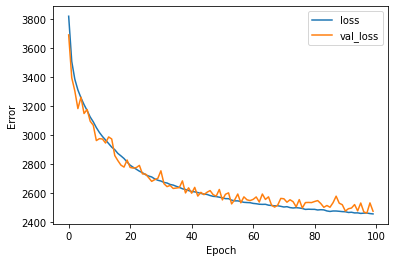

In [ ]:
plot_loss(history)

In [ ]:
test_results = dnn_model1.evaluate(X_val_states.iloc[:, 1:], y_val_states, verbose=0)

In [ ]:
test_results

1493.147216796875

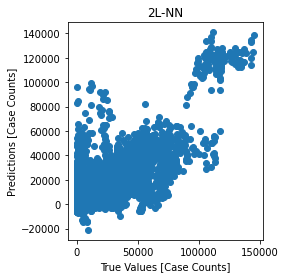

In [ ]:
val_predictions_nnmodel1 = dnn_model1.predict(X_val_states.iloc[:, 1:]).flatten()

a = plt.axes(aspect='equal')
plt.scatter(y_val_states, val_predictions_nnmodel1)
plt.title('2L-NN')
plt.xlabel('True Values [Case Counts]')
plt.ylabel('Predictions [Case Counts]')
plt.show()

In [ ]:
corr_nn2, _ = pearsonr(y_val_states, val_predictions_nnmodel1)
print("Pearson Correlation Coefficient = ", corr_nn2) # Note: r = 0.5 - 1.0 means strong positive association
print("Mean Abolsute Error = ", mean_absolute_error(y_val_states, val_predictions_nnmodel1))


Pearson Correlation Coefficient =  0.8508747639044546
Mean Abolsute Error =  1493.1480565248035


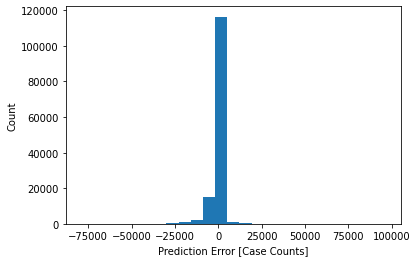

In [ ]:
error = val_predictions_nnmodel1 - y_val_states
plt.hist(error, bins=25)
plt.xlabel('Prediction Error [Case Counts]')
_ = plt.ylabel('Count')

In [ ]:
dnn_model1.save('dnn_model1')

INFO:tensorflow:Assets written to: dnn_model1/assets


## 3 Layer NN (Tensorflow)

In [ ]:
def build_and_compile_model2(norm):
  model = keras.Sequential([
      norm,
      layers.Dense(64, activation='relu'),
      layers.Dense(64, activation='relu'),
      layers.Dense(64, activation='relu'),
      layers.Dense(1)
  ])

  model.compile(loss='mean_absolute_error',
                optimizer=tf.keras.optimizers.Adam(0.01))
  return model

In [ ]:
dnn_model2 = build_and_compile_model2(normalizer)
dnn_model2.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization_1 (Normalizat  (None, 17)               35        
 ion)                                                            
                                                                 
 dense_6 (Dense)             (None, 64)                1152      
                                                                 
 dense_7 (Dense)             (None, 64)                4160      
                                                                 
 dense_8 (Dense)             (None, 64)                4160      
                                                                 
 dense_9 (Dense)             (None, 1)                 65        
                                                                 
Total params: 9,572
Trainable params: 9,537
Non-trainable params: 35
___________________________________________________

In [ ]:
%%time
history2 = dnn_model2.fit(
    Xtrain2_tf,
    y_train2,
    validation_split=0.2,
    verbose=1, epochs=100)

Epoch 1/100
31833/31833 [==============================] - 74s 2ms/step - loss: 3727.5515 - val_loss: 3372.2725
Epoch 2/100
31833/31833 [==============================] - 74s 2ms/step - loss: 3381.3850 - val_loss: 3321.1001
Epoch 3/100
31833/31833 [==============================] - 78s 2ms/step - loss: 3222.9709 - val_loss: 3057.2896
Epoch 4/100
31833/31833 [==============================] - 76s 2ms/step - loss: 3114.5989 - val_loss: 2967.3032
Epoch 5/100
31833/31833 [==============================] - 75s 2ms/step - loss: 3022.8230 - val_loss: 3091.2961
Epoch 6/100
31833/31833 [==============================] - 73s 2ms/step - loss: 2945.7124 - val_loss: 2941.2681
Epoch 7/100
31833/31833 [==============================] - 72s 2ms/step - loss: 2874.7502 - val_loss: 2825.3032
Epoch 8/100
31833/31833 [==============================] - 71s 2ms/step - loss: 2817.1851 - val_loss: 2786.9673
Epoch 9/100
31833/31833 [==============================] - 74s 2ms/step - loss: 2777.1206 - val_loss: 27

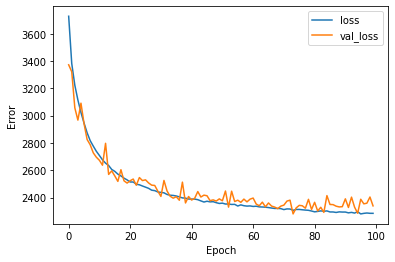

In [ ]:
plot_loss(history2)

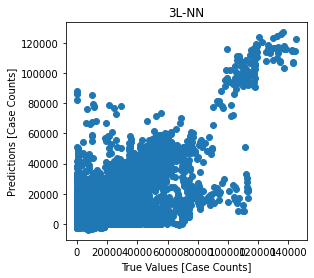

In [ ]:
val_predictions_nnmodel2 = dnn_model2.predict(X_val_states.iloc[:, 1:]).flatten()

a = plt.axes(aspect='equal')
plt.scatter(y_val_states, val_predictions_nnmodel2)
plt.title('3L-NN')
plt.xlabel('True Values [Case Counts]')
plt.ylabel('Predictions [Case Counts]')
plt.show()

In [ ]:
corr_nn3, _ = pearsonr(y_val_states, val_predictions_nnmodel2)
print("Pearson Correlation Coefficient = ", corr_nn3) # Note: r = 0.5 - 1.0 means strong positive association
print("Mean Abolsute Error = ", mean_absolute_error(y_val_states, val_predictions_nnmodel2))

Pearson Correlation Coefficient =  0.8135842492497687
Mean Abolsute Error =  1653.832987318188


In [ ]:
dnn_model2.save('dnn_model2')

INFO:tensorflow:Assets written to: dnn_model2/assets


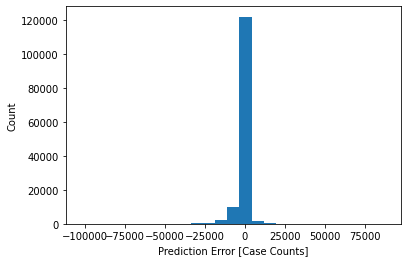

In [ ]:
error = val_predictions_nnmodel2 - y_val_states
plt.hist(error, bins=25)
plt.xlabel('Prediction Error [Case Counts]')
_ = plt.ylabel('Count')

## 10 Layer NN (Tensorflow)

In [ ]:
def build_and_compile_model3(norm):
  model = keras.Sequential([
      norm,
      layers.Dense(64, activation='relu'),
      layers.Dense(64, activation='relu'),
      layers.Dense(64, activation='relu'),
      layers.Dense(64, activation='relu'),
      layers.Dense(64, activation='relu'),
      layers.Dense(64, activation='relu'),
      layers.Dense(64, activation='relu'),
      layers.Dense(64, activation='relu'),
      layers.Dense(64, activation='relu'),
      layers.Dense(64, activation='relu'),
      layers.Dense(1)
  ])

  model.compile(loss='mean_absolute_error',
                optimizer=tf.keras.optimizers.Adam(0.01))
  return model

In [ ]:
dnn_model3 = build_and_compile_model3(normalizer)
dnn_model3.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization_1 (Normalizat  (None, 17)               35        
 ion)                                                            
                                                                 
 dense_10 (Dense)            (None, 64)                1152      
                                                                 
 dense_11 (Dense)            (None, 64)                4160      
                                                                 
 dense_12 (Dense)            (None, 64)                4160      
                                                                 
 dense_13 (Dense)            (None, 64)                4160      
                                                                 
 dense_14 (Dense)            (None, 64)                4160      
                                                      

In [ ]:
%%time
history3 = dnn_model3.fit(
    Xtrain2_tf,
    y_train2,
    validation_split=0.2,
    verbose=1, epochs=100)

Epoch 1/100
31833/31833 [==============================] - 92s 3ms/step - loss: 3863.0164 - val_loss: 3801.4731
Epoch 2/100
31833/31833 [==============================] - 92s 3ms/step - loss: 3539.7375 - val_loss: 4116.6479
Epoch 3/100
31833/31833 [==============================] - 91s 3ms/step - loss: 3461.9692 - val_loss: 3579.1125
Epoch 4/100
31833/31833 [==============================] - 89s 3ms/step - loss: 3387.0110 - val_loss: 3206.4932
Epoch 5/100
31833/31833 [==============================] - 95s 3ms/step - loss: 3307.6885 - val_loss: 3196.8354
Epoch 6/100
31833/31833 [==============================] - 88s 3ms/step - loss: 3288.5376 - val_loss: 3266.0664
Epoch 7/100
31833/31833 [==============================] - 91s 3ms/step - loss: 3217.6843 - val_loss: 3067.6250
Epoch 8/100
31833/31833 [==============================] - 91s 3ms/step - loss: 3240.5461 - val_loss: 3251.3982
Epoch 9/100
31833/31833 [==============================] - 91s 3ms/step - loss: 3211.8689 - val_loss: 31

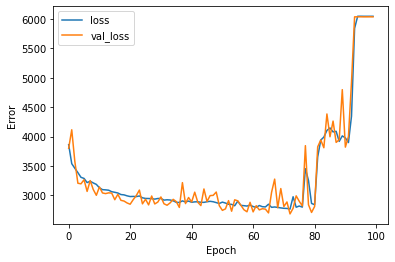

In [ ]:
plot_loss(history3)

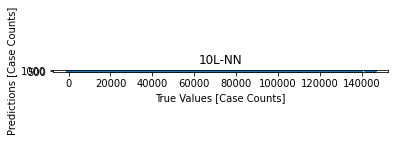

In [ ]:
val_predictions_nnmodel3 = dnn_model3.predict(X_val_states.iloc[:, 1:]).flatten()

a = plt.axes(aspect='equal')
plt.scatter(y_val_states, val_predictions_nnmodel3)
plt.title('10L-NN')
plt.xlabel('True Values [Case Counts]')
plt.ylabel('Predictions [Case Counts]')
plt.show()

In [ ]:
corr_nn10, _ = pearsonr(y_val_states, val_predictions_nnmodel3)
print("Pearson Correlation Coefficient = ", corr_nn10) # Note: r = 0.5 - 1.0 means strong positive association
print("Mean Abolsute Error = ", mean_absolute_error(y_val_states, val_predictions_nnmodel3))

Pearson Correlation Coefficient =  0.018013689030761164
Mean Abolsute Error =  2659.621369107628


In [ ]:
dnn_model3.save('dnn_model3')

INFO:tensorflow:Assets written to: dnn_model3/assets


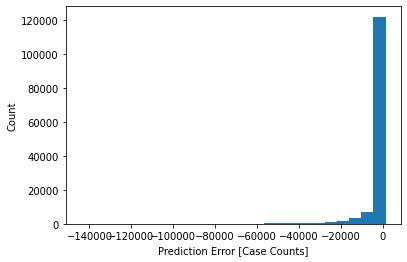

In [ ]:
error = val_predictions_nnmodel3 - y_val_states
plt.hist(error, bins=25)
plt.xlabel('Prediction Error [Case Counts]')
_ = plt.ylabel('Count')

## Test NN in TF

In [ ]:
def build_and_compile_model4(norm):
  model = keras.Sequential([
      norm,
      layers.Dense(64, activation='relu'),
      layers.Dense(64, activation='relu'),
      layers.Dense(32, activation='relu'),
      layers.Dense(16, activation='relu'),
      layers.Dense(1)
  ])

  model.compile(loss='mean_absolute_error',
                optimizer=tf.keras.optimizers.Adam(0.01))
  return model

dnn_model4 = build_and_compile_model4(normalizer)
dnn_model4.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization_1 (Normalizat  (None, 17)               35        
 ion)                                                            
                                                                 
 dense_21 (Dense)            (None, 64)                1152      
                                                                 
 dense_22 (Dense)            (None, 64)                4160      
                                                                 
 dense_23 (Dense)            (None, 32)                2080      
                                                                 
 dense_24 (Dense)            (None, 16)                528       
                                                                 
 dense_25 (Dense)            (None, 1)                 17        
                                                      

In [ ]:
%%time
history4 = dnn_model4.fit(
    Xtrain2_tf,
    y_train2,
    validation_split=0.2,
    verbose=1, epochs=100)

Epoch 1/100
31833/31833 [==============================] - 66s 2ms/step - loss: 3705.5608 - val_loss: 3556.0522
Epoch 2/100
31833/31833 [==============================] - 68s 2ms/step - loss: 3394.6555 - val_loss: 3384.8042
Epoch 3/100
31833/31833 [==============================] - 65s 2ms/step - loss: 3263.9756 - val_loss: 3102.9202
Epoch 4/100
31833/31833 [==============================] - 65s 2ms/step - loss: 3164.8064 - val_loss: 3172.8347
Epoch 5/100
31833/31833 [==============================] - 65s 2ms/step - loss: 3084.5503 - val_loss: 3163.1716
Epoch 6/100
31833/31833 [==============================] - 67s 2ms/step - loss: 3013.3491 - val_loss: 3175.6848
Epoch 7/100
31833/31833 [==============================] - 65s 2ms/step - loss: 2945.3442 - val_loss: 2808.9866
Epoch 8/100
31833/31833 [==============================] - 65s 2ms/step - loss: 2901.0125 - val_loss: 2851.7979
Epoch 9/100
31833/31833 [==============================] - 64s 2ms/step - loss: 2854.4282 - val_loss: 27

KeyboardInterrupt: ignored

In [ ]:
plot_loss(history4)

In [ ]:
val_predictions_nnmodel4 = dnn_model4.predict(X_val_states.iloc[:, 1:]).flatten()

a = plt.axes(aspect='equal')
plt.scatter(y_val_states, val_predictions_nnmodel3)
plt.title('4L-NN')
plt.xlabel('True Values [Case Counts]')
plt.ylabel('Predictions [Case Counts]')
plt.show()

In [ ]:
corr_nnCustom, _ = pearsonr(y_val_states, val_predictions_nnmodel4)
print("Pearson Correlation Coefficient = ", corr_nnCustom) # Note: r = 0.5 - 1.0 means strong positive association
print("Mean Abolsute Error = ", mean_absolute_error(y_val_states, val_predictions_nnmodel4))

In [ ]:
dnn_model4.save('dnn_model4')

In [ ]:
error = val_predictions_nnmodel4 - y_val_states
plt.hist(error, bins=25)
plt.xlabel('Prediction Error [Case Counts]')
_ = plt.ylabel('Count')

## 7 Layer NN with Varying Width (32 - 64 - 128 - 64 - 32 - 16 - 1)

In [12]:
def build_and_compile_model5(norm):
  model = keras.Sequential([
      norm,
      layers.Dense(32, activation='relu'),
      layers.Dense(64, activation='relu'),
      layers.Dense(128, activation='relu'),
      layers.Dense(64, activation='relu'),
      layers.Dense(32, activation='relu'),
      layers.Dense(16, activation='relu'),
      layers.Dense(1)
  ])

  model.compile(loss='mean_absolute_error',
                optimizer=tf.keras.optimizers.Adam(0.01))
  return model

dnn_model5 = build_and_compile_model5(normalizer)
dnn_model5.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization (Normalizatio  (None, 17)               35        
 n)                                                              
                                                                 
 dense (Dense)               (None, 32)                576       
                                                                 
 dense_1 (Dense)             (None, 64)                2112      
                                                                 
 dense_2 (Dense)             (None, 128)               8320      
                                                                 
 dense_3 (Dense)             (None, 64)                8256      
                                                                 
 dense_4 (Dense)             (None, 32)                2080      
                                                        

In [13]:
%%time
history5 = dnn_model5.fit(
    Xtrain2_tf,
    y_train2,
    validation_split=0.2,
    verbose=1, epochs=100)

Epoch 1/100
31833/31833 [==============================] - 87s 3ms/step - loss: 3720.6753 - val_loss: 3637.6809
Epoch 2/100
31833/31833 [==============================] - 85s 3ms/step - loss: 3434.2812 - val_loss: 3732.9109
Epoch 3/100
31833/31833 [==============================] - 85s 3ms/step - loss: 3300.4546 - val_loss: 3243.8340
Epoch 4/100
31833/31833 [==============================] - 85s 3ms/step - loss: 3215.4602 - val_loss: 3180.4875
Epoch 5/100
31833/31833 [==============================] - 85s 3ms/step - loss: 3152.2712 - val_loss: 3069.4368
Epoch 6/100
31833/31833 [==============================] - 85s 3ms/step - loss: 3098.0103 - val_loss: 3053.2590
Epoch 7/100
31833/31833 [==============================] - 84s 3ms/step - loss: 3056.5415 - val_loss: 2988.0935
Epoch 8/100
31833/31833 [==============================] - 84s 3ms/step - loss: 3007.4497 - val_loss: 2974.3733
Epoch 9/100
31833/31833 [==============================] - 84s 3ms/step - loss: 2988.9468 - val_loss: 28

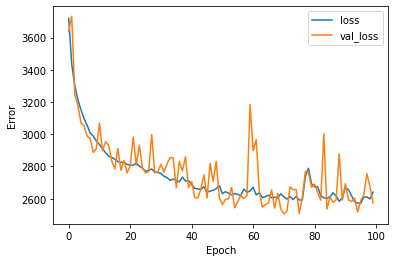

In [14]:
plot_loss(history5)

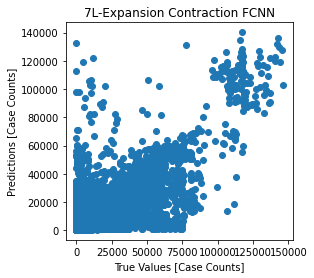

In [15]:
val_predictions_nnmodel5 = dnn_model5.predict(X_val_states.iloc[:, 1:]).flatten()

a = plt.axes(aspect='equal')
plt.scatter(y_val_states, val_predictions_nnmodel5)
plt.title('7L-Expansion Contraction FCNN')
plt.xlabel('True Values [Case Counts]')
plt.ylabel('Predictions [Case Counts]')
plt.show()

In [16]:
corr_nnCustom, _ = pearsonr(y_val_states, val_predictions_nnmodel5)
print("Pearson Correlation Coefficient = ", corr_nnCustom) # Note: r = 0.5 - 1.0 means strong positive association
print("Mean Abolsute Error = ", mean_absolute_error(y_val_states, val_predictions_nnmodel5))

Pearson Correlation Coefficient =  0.8200906686921089
Mean Abolsute Error =  1664.354521398934


In [17]:
dnn_model5.save(FOLDERNAME+'/modelFCNN7Layers')

INFO:tensorflow:Assets written to: /content/drive/MyDrive/CS230_FINAL_PROJECT/modelFCNN7Layers/assets


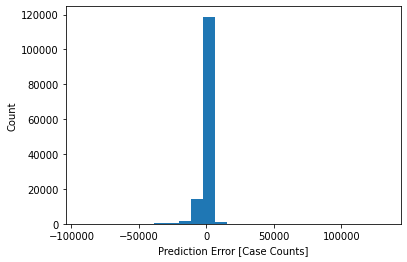

In [18]:
error = val_predictions_nnmodel5 - y_val_states
plt.hist(error, bins=25)
plt.xlabel('Prediction Error [Case Counts]')
_ = plt.ylabel('Count')

## 4 Layer NN with Varying Width (16 - 32 - 16 - 1)

In [23]:
def build_and_compile_model8(norm):
  model = keras.Sequential([
      norm,
      layers.Dense(16, activation='relu'),
      layers.Dense(32, activation='relu'),
      layers.Dense(16, activation='relu'),
      layers.Dense(1)
  ])

  model.compile(loss='mean_absolute_error',
                optimizer=tf.keras.optimizers.Adam(0.01))
  return model

dnn_model8 = build_and_compile_model8(normalizer)
dnn_model8.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization (Normalizatio  (None, 17)               35        
 n)                                                              
                                                                 
 dense_19 (Dense)            (None, 16)                288       
                                                                 
 dense_20 (Dense)            (None, 32)                544       
                                                                 
 dense_21 (Dense)            (None, 16)                528       
                                                                 
 dense_22 (Dense)            (None, 1)                 17        
                                                                 
Total params: 1,412
Trainable params: 1,377
Non-trainable params: 35
___________________________________________________

In [24]:
%%time
history8 = dnn_model8.fit(
    Xtrain2_tf,
    y_train2,
    validation_split=0.2,
    verbose=1, epochs=100)

Epoch 1/100
31833/31833 [==============================] - 75s 2ms/step - loss: 3787.5286 - val_loss: 3579.7141
Epoch 2/100
31833/31833 [==============================] - 74s 2ms/step - loss: 3545.6270 - val_loss: 3401.8228
Epoch 3/100
31833/31833 [==============================] - 75s 2ms/step - loss: 3427.2146 - val_loss: 3400.7676
Epoch 4/100
31833/31833 [==============================] - 75s 2ms/step - loss: 3350.6196 - val_loss: 3238.3743
Epoch 5/100
31833/31833 [==============================] - 75s 2ms/step - loss: 3280.3918 - val_loss: 3229.2141
Epoch 6/100
31833/31833 [==============================] - 74s 2ms/step - loss: 3236.9097 - val_loss: 3349.2214
Epoch 7/100
31833/31833 [==============================] - 75s 2ms/step - loss: 3192.6824 - val_loss: 3124.7263
Epoch 8/100
31833/31833 [==============================] - 74s 2ms/step - loss: 3154.9409 - val_loss: 3101.0232
Epoch 9/100
31833/31833 [==============================] - 75s 2ms/step - loss: 3124.8010 - val_loss: 31

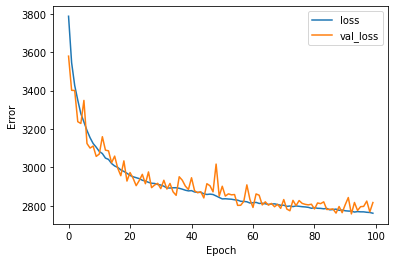

In [25]:
plot_loss(history8)

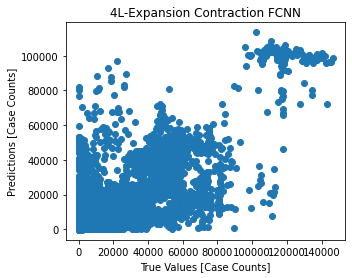

In [26]:
val_predictions_nnmodel8 = dnn_model8.predict(X_val_states.iloc[:, 1:]).flatten()

a = plt.axes(aspect='equal')
plt.scatter(y_val_states, val_predictions_nnmodel8)
plt.title('4L-Expansion Contraction FCNN')
plt.xlabel('True Values [Case Counts]')
plt.ylabel('Predictions [Case Counts]')
plt.show()

In [27]:
corr_nnCustom, _ = pearsonr(y_val_states, val_predictions_nnmodel8)
print("Pearson Correlation Coefficient = ", corr_nnCustom) # Note: r = 0.5 - 1.0 means strong positive association
print("Mean Abolsute Error = ", mean_absolute_error(y_val_states, val_predictions_nnmodel8))

Pearson Correlation Coefficient =  0.8282978917793711
Mean Abolsute Error =  1567.432036514753


In [28]:
dnn_model8.save(FOLDERNAME+'/modelFCNN4Layers')

INFO:tensorflow:Assets written to: /content/drive/MyDrive/CS230_FINAL_PROJECT/modelFCNN4Layers/assets


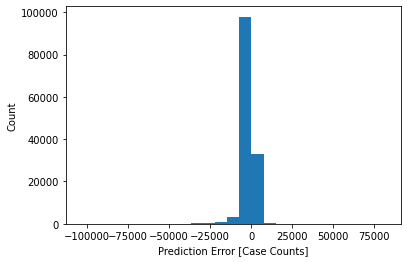

In [29]:
error = val_predictions_nnmodel8 - y_val_states
plt.hist(error, bins=25)
plt.xlabel('Prediction Error [Case Counts]')
_ = plt.ylabel('Count')

## 3 Layer NN (width = 16, Tensorflow)

In [ ]:
def build_and_compile_model6(norm):
  model = keras.Sequential([
      norm,
      layers.Dense(16, activation='relu'),
      layers.Dense(16, activation='relu'),
      layers.Dense(16, activation='relu'),
      layers.Dense(1)
  ])

  model.compile(loss='mean_absolute_error',
                optimizer=tf.keras.optimizers.Adam(0.01))
  return model

dnn_model6 = build_and_compile_model6(normalizer)
dnn_model6.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization_1 (Normalizat  (None, 17)               35        
 ion)                                                            
                                                                 
 dense_26 (Dense)            (None, 16)                288       
                                                                 
 dense_27 (Dense)            (None, 16)                272       
                                                                 
 dense_28 (Dense)            (None, 16)                272       
                                                                 
 dense_29 (Dense)            (None, 1)                 17        
                                                                 
Total params: 884
Trainable params: 849
Non-trainable params: 35
_______________________________________________________

In [ ]:
%%time
history6 = dnn_model6.fit(
    Xtrain2_tf,
    y_train2,
    validation_split=0.2,
    verbose=1, epochs=100)

Epoch 1/100
31833/31833 [==============================] - 56s 2ms/step - loss: 3901.0610 - val_loss: 3857.0088
Epoch 2/100
31833/31833 [==============================] - 56s 2ms/step - loss: 3810.2451 - val_loss: 3823.0813
Epoch 3/100
31833/31833 [==============================] - 56s 2ms/step - loss: 3693.3972 - val_loss: 3518.2139
Epoch 4/100
31833/31833 [==============================] - 59s 2ms/step - loss: 3541.8931 - val_loss: 3468.0903
Epoch 5/100
31833/31833 [==============================] - 57s 2ms/step - loss: 3486.7224 - val_loss: 3462.1233
Epoch 6/100
31833/31833 [==============================] - 56s 2ms/step - loss: 3442.8667 - val_loss: 3415.7161
Epoch 7/100
31833/31833 [==============================] - 56s 2ms/step - loss: 3398.1851 - val_loss: 3482.2346
Epoch 8/100
31833/31833 [==============================] - 56s 2ms/step - loss: 3366.6973 - val_loss: 3343.7839
Epoch 9/100
31833/31833 [==============================] - 56s 2ms/step - loss: 3344.3894 - val_loss: 33

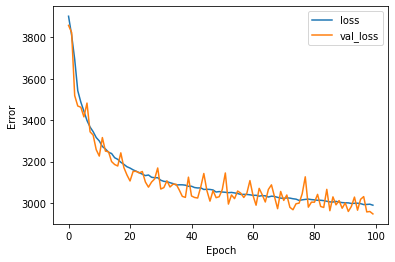

In [ ]:
plot_loss(history6)

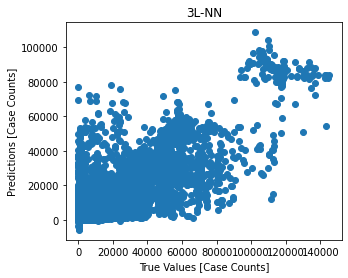

In [ ]:
val_predictions_nnmodel6 = dnn_model6.predict(X_val_states.iloc[:, 1:]).flatten()

a = plt.axes(aspect='equal')
plt.scatter(y_val_states, val_predictions_nnmodel6)
plt.title('3L-NN')
plt.xlabel('True Values [Case Counts]')
plt.ylabel('Predictions [Case Counts]')
plt.show()

In [ ]:
corr_nnCustom, _ = pearsonr(y_val_states, val_predictions_nnmodel6)
print("Pearson Correlation Coefficient = ", corr_nnCustom) # Note: r = 0.5 - 1.0 means strong positive association
print("Mean Abolsute Error = ", mean_absolute_error(y_val_states, val_predictions_nnmodel6))

Pearson Correlation Coefficient =  0.8477775495306838
Mean Abolsute Error =  1536.0461155690748


In [ ]:
dnn_model6.save('dnn_model6')

INFO:tensorflow:Assets written to: dnn_model6/assets


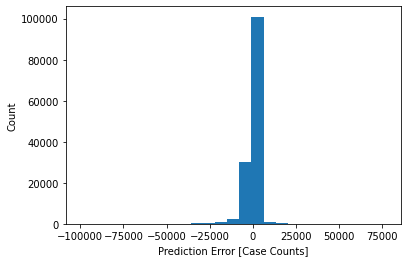

In [ ]:
error = val_predictions_nnmodel6 - y_val_states
plt.hist(error, bins=25)
plt.xlabel('Prediction Error [Case Counts]')
_ = plt.ylabel('Count')

## 3 Layer NN (width = 9, Tensorflow)

In [ ]:
def build_and_compile_model7(norm):
  model = keras.Sequential([
      norm,
      layers.Dense(9, activation='relu'),
      layers.Dense(9, activation='relu'),
      layers.Dense(9, activation='relu'),
      layers.Dense(1)
  ])

  model.compile(loss='mean_absolute_error',
                optimizer=tf.keras.optimizers.Adam(0.01))
  return model

dnn_model7 = build_and_compile_model7(normalizer)
dnn_model7.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization_1 (Normalizat  (None, 17)               35        
 ion)                                                            
                                                                 
 dense_30 (Dense)            (None, 9)                 162       
                                                                 
 dense_31 (Dense)            (None, 9)                 90        
                                                                 
 dense_32 (Dense)            (None, 9)                 90        
                                                                 
 dense_33 (Dense)            (None, 1)                 10        
                                                                 
Total params: 387
Trainable params: 352
Non-trainable params: 35
_______________________________________________________

In [ ]:
%%time
history7 = dnn_model7.fit(
    Xtrain2_tf,
    y_train2,
    validation_split=0.2,
    verbose=1, epochs=100)

Epoch 1/100
31833/31833 [==============================] - 59s 2ms/step - loss: 3903.9307 - val_loss: 3767.9944
Epoch 2/100
31833/31833 [==============================] - 62s 2ms/step - loss: 3810.4631 - val_loss: 3723.9900
Epoch 3/100
31833/31833 [==============================] - 60s 2ms/step - loss: 3772.2854 - val_loss: 3700.1653
Epoch 4/100
31833/31833 [==============================] - 60s 2ms/step - loss: 3745.5432 - val_loss: 3668.3906
Epoch 5/100
31833/31833 [==============================] - 59s 2ms/step - loss: 3730.3423 - val_loss: 3664.6680
Epoch 6/100
31833/31833 [==============================] - 59s 2ms/step - loss: 3718.6033 - val_loss: 3666.3989
Epoch 7/100
31833/31833 [==============================] - 59s 2ms/step - loss: 3692.9248 - val_loss: 3610.3547
Epoch 8/100
31833/31833 [==============================] - 60s 2ms/step - loss: 3558.7681 - val_loss: 3449.1375
Epoch 9/100
31833/31833 [==============================] - 62s 2ms/step - loss: 3459.3223 - val_loss: 34

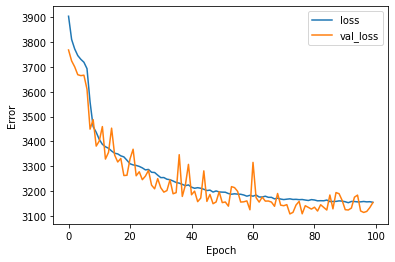

In [ ]:
plot_loss(history7)

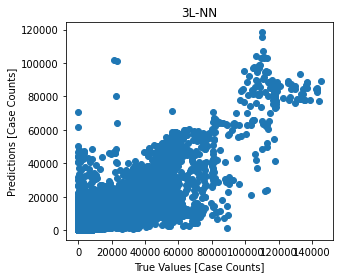

In [ ]:
val_predictions_nnmodel7 = dnn_model7.predict(X_val_states.iloc[:, 1:]).flatten()

a = plt.axes(aspect='equal')
plt.scatter(y_val_states, val_predictions_nnmodel7)
plt.title('3L-NN')
plt.xlabel('True Values [Case Counts]')
plt.ylabel('Predictions [Case Counts]')
plt.show()

In [ ]:
corr_nnCustom, _ = pearsonr(y_val_states, val_predictions_nnmodel7)
print("Pearson Correlation Coefficient = ", corr_nnCustom) # Note: r = 0.5 - 1.0 means strong positive association
print("Mean Abolsute Error = ", mean_absolute_error(y_val_states, val_predictions_nnmodel7))

Pearson Correlation Coefficient =  0.8550344236043702
Mean Abolsute Error =  1561.40335283319


In [ ]:
dnn_model7.save('dnn_model7')

INFO:tensorflow:Assets written to: dnn_model7/assets


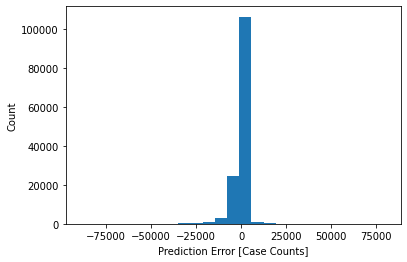

In [ ]:
error = val_predictions_nnmodel7 - y_val_states
plt.hist(error, bins=25)
plt.xlabel('Prediction Error [Case Counts]')
_ = plt.ylabel('Count')

## 2 Layer NN (width = 16, Tensorflow)

In [30]:
def build_and_compile_model9(norm):
  model = keras.Sequential([
      norm,
      layers.Dense(16, activation='relu'),
      layers.Dense(16, activation='relu'),
      layers.Dense(1)
  ])

  model.compile(loss='mean_absolute_error',
                optimizer=tf.keras.optimizers.Adam(0.01))
  return model

dnn_model9 = build_and_compile_model9(normalizer)
dnn_model9.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization (Normalizatio  (None, 17)               35        
 n)                                                              
                                                                 
 dense_23 (Dense)            (None, 16)                288       
                                                                 
 dense_24 (Dense)            (None, 16)                272       
                                                                 
 dense_25 (Dense)            (None, 1)                 17        
                                                                 
Total params: 612
Trainable params: 577
Non-trainable params: 35
_________________________________________________________________


In [31]:
%%time
history9 = dnn_model9.fit(
    Xtrain2,
    y_train2,
    validation_split=0.2,
    verbose=1, epochs=100)

Epoch 1/100
31833/31833 [==============================] - 72s 2ms/step - loss: 3802.7478 - val_loss: 3605.6350
Epoch 2/100
31833/31833 [==============================] - 72s 2ms/step - loss: 3575.1775 - val_loss: 3497.7832
Epoch 3/100
31833/31833 [==============================] - 73s 2ms/step - loss: 3489.8164 - val_loss: 3424.9087
Epoch 4/100
31833/31833 [==============================] - 73s 2ms/step - loss: 3434.7876 - val_loss: 3402.6487
Epoch 5/100
31833/31833 [==============================] - 73s 2ms/step - loss: 3388.0437 - val_loss: 3345.8906
Epoch 6/100
31833/31833 [==============================] - 73s 2ms/step - loss: 3359.4346 - val_loss: 3324.0381
Epoch 7/100
31833/31833 [==============================] - 73s 2ms/step - loss: 3339.4529 - val_loss: 3311.7510
Epoch 8/100
31833/31833 [==============================] - 72s 2ms/step - loss: 3323.1326 - val_loss: 3294.0396
Epoch 9/100
31833/31833 [==============================] - 72s 2ms/step - loss: 3303.3015 - val_loss: 32

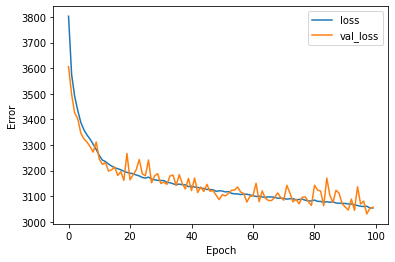

In [32]:
plot_loss(history9)

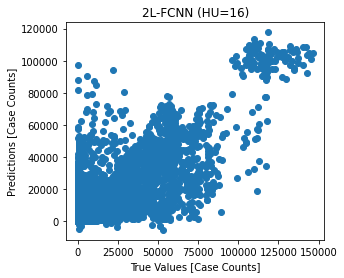

In [33]:
val_predictions_nnmodel9 = dnn_model9.predict(X_val_states).flatten()

a = plt.axes(aspect='equal')
plt.scatter(y_val_states, val_predictions_nnmodel9)
plt.title('2L-FCNN (HU=16)')
plt.xlabel('True Values [Case Counts]')
plt.ylabel('Predictions [Case Counts]')
plt.show()

In [34]:
corr_nnCustom, _ = pearsonr(y_val_states, val_predictions_nnmodel9)
print("Pearson Correlation Coefficient = ", corr_nnCustom) # Note: r = 0.5 - 1.0 means strong positive association
print("Mean Abolsute Error = ", mean_absolute_error(y_val_states, val_predictions_nnmodel9))

Pearson Correlation Coefficient =  0.8583108981641427
Mean Abolsute Error =  1502.3515293649955


In [35]:
dnn_model9.save(FOLDERNAME+'/dnn_model9')

INFO:tensorflow:Assets written to: /content/drive/MyDrive/CS230_FINAL_PROJECT/dnn_model9/assets


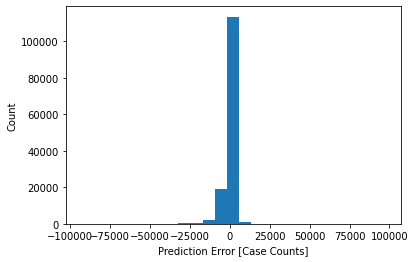

In [36]:
error = val_predictions_nnmodel9 - y_val_states
plt.hist(error, bins=25)
plt.xlabel('Prediction Error [Case Counts]')
_ = plt.ylabel('Count')

## Test Set Performance

In [130]:
X_test_states

,Number of Trips <1,Number of Trips 1-3,Number of Trips 3-5,Number of Trips 5-10,Number of Trips 10-25,Number of Trips 25-50,Number of Trips 50-100,Number of Trips 100-250,Number of Trips 250-500,Number of Trips >=500,Civilian_labor_force_2020,Employed_2020,Unemployed_2020,Unemployment_rate_2020,Median_Household_Income_2019,Med_HH_Income_Percent_of_State_Total_2019,POVALL_2019,POV017_2019
909737,19214.0,19473.0,5217.0,8018.0,13421.0,8037.0,1729.0,1415.0,289.0,16.0,14468,13880,588,4.1,63975,103.5,2227,552
849595,10279.0,9662.0,4846.0,5997.0,5337.0,5799.0,946.0,405.0,62.0,19.0,10009,9565,444,4.4,66861,108.2,1056,302
679844,44918.0,48543.0,23124.0,28939.0,24772.0,5559.0,3618.0,1239.0,179.0,58.0,23558,22008,1550,6.6,46683,90.2,7998,2204
677069,18470.0,19417.0,8665.0,13940.0,12422.0,7507.0,5388.0,576.0,51.0,9.0,9056,8255,801,8.8,39944,77.2,4124,1460
1071048,1273.0,418.0,296.0,243.0,1882.0,843.0,582.0,0.0,0.0,4.0,969,942,27,2.8,41240,72.0,425,115
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
676188,33731.0,39629.0,20471.0,28249.0,34215.0,17619.0,5634.0,1218.0,564.0,28.0,24661,23653,1008,4.1,52902,102.2,9324,2750
850286,35591.0,32981.0,14229.0,16047.0,19825.0,12885.0,4867.0,1058.0,211.0,45.0,17514,16278,1236,7.1,55631,90.0,4947,1482
141930,94806.0,96262.0,32775.0,42436.0,26690.0,20220.0,9462.0,4626.0,657.0,656.0,70434,66898,3536,5.0,73731,128.8,11486,1696
1479488,9874.0,13168.0,4454.0,5178.0,4269.0,3710.0,1360.0,1187.0,148.0,6.0,4644,4475,169,3.6,53085,85.9,1263,432


In [131]:
new_model = tf.keras.models.load_model(FOLDERNAME+'/dnn_model9')

test_predictions = new_model.predict(X_test_states.iloc[:, 1:]).flatten()

In [132]:
print('Test Min = ', test_predictions.min())
print('Test Max = ', test_predictions.max())

Test Min =  -6058.7266
Test Max =  111901.82


In [133]:
new_model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization (Normalizatio  (None, 17)               35        
 n)                                                              
                                                                 
 dense_23 (Dense)            (None, 16)                288       
                                                                 
 dense_24 (Dense)            (None, 16)                272       
                                                                 
 dense_25 (Dense)            (None, 1)                 17        
                                                                 
Total params: 612
Trainable params: 577
Non-trainable params: 35
_________________________________________________________________


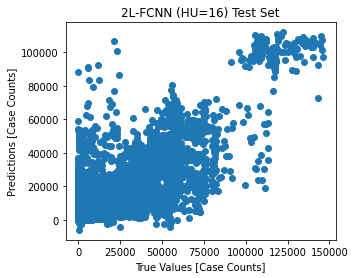

In [134]:
a = plt.axes(aspect='equal')
plt.scatter(y_test_states, test_predictions)
plt.title('2L-FCNN (HU=16) Test Set')
plt.xlabel('True Values [Case Counts]')
plt.ylabel('Predictions [Case Counts]')
plt.show()

In [135]:
corr_nnCustom, _ = pearsonr(y_test_states, test_predictions)
print("Pearson Correlation Coefficient = ", corr_nnCustom) # Note: r = 0.5 - 1.0 means strong positive association
print("Mean Abolsute Error = ", mean_absolute_error(y_test_states, test_predictions))

Pearson Correlation Coefficient =  0.8559363282813206
Mean Abolsute Error =  1514.0859480979852


# Data Processing & Dataset Preparation (MOST RECENT DATA)

In [136]:
travel_data_raw_REC = pd.read_csv(FOLDERNAME + "/Trips_by_Distance_Recent.csv", thousands=',')
covid_counts_raw_REC = pd.read_csv(FOLDERNAME + "/us-counties-recent.csv")

In [137]:
#travel_data_raw.head()
travel_counties_REC = travel_data_raw_REC.loc[travel_data_raw_REC['Level'] == "County"]
travel_counties_final_REC = travel_counties_REC[['Date', 'State Postal Code', 'County Name', 'Number of Trips', 'Number of Trips <1', 'Number of Trips 1-3', 'Number of Trips 3-5', 'Number of Trips 5-10', 'Number of Trips 10-25', 'Number of Trips 25-50', 'Number of Trips 50-100', 'Number of Trips 100-250', 'Number of Trips 250-500', 'Number of Trips >=500']]
travel_counties_final_REC['County Name'] = travel_counties_final_REC['County Name'].apply(lambda x: x.split(" ")[0])
travel_counties_final_REC = travel_counties_final_REC.rename(columns={"Date": "date", "State Postal Code": "state", "County Name": "county"})
travel_counties_final_REC.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


,date,state,county,Number of Trips,Number of Trips <1,Number of Trips 1-3,Number of Trips 3-5,Number of Trips 5-10,Number of Trips 10-25,Number of Trips 25-50,Number of Trips 50-100,Number of Trips 100-250,Number of Trips 250-500,Number of Trips >=500
21061,2021/06/06,WY,Weston,22471.0,4160.0,2601.0,948.0,1558.0,5723.0,2202.0,3930.0,1160.0,166.0,23.0
22762,2021/06/06,AR,Bradley,25022.0,3411.0,4145.0,5901.0,4321.0,3343.0,1793.0,1383.0,690.0,35.0,0.0
22763,2021/06/06,AR,Calhoun,17543.0,2166.0,2168.0,3195.0,3600.0,4277.0,1141.0,530.0,425.0,41.0,0.0
22764,2021/06/06,AR,Carroll,77047.0,14712.0,16029.0,11434.0,13170.0,14712.0,4272.0,1227.0,1323.0,132.0,36.0
22765,2021/06/06,AR,Chicot,31550.0,9483.0,6752.0,4547.0,3929.0,3857.0,1380.0,580.0,957.0,61.0,4.0


In [138]:
covid_counts_final_REC = covid_counts_raw_REC[['date', 'county', 'state', 'cases']]
covid_counts_final_REC['date'] = covid_counts_final_REC['date'].apply(lambda x: x.replace('-', '/'))
us_state_to_abbrev = {
    "Alabama": "AL",
    "Alaska": "AK",
    "Arizona": "AZ",
    "Arkansas": "AR",
    "California": "CA",
    "Colorado": "CO",
    "Connecticut": "CT",
    "Delaware": "DE",
    "Florida": "FL",
    "Georgia": "GA",
    "Hawaii": "HI",
    "Idaho": "ID",
    "Illinois": "IL",
    "Indiana": "IN",
    "Iowa": "IA",
    "Kansas": "KS",
    "Kentucky": "KY",
    "Louisiana": "LA",
    "Maine": "ME",
    "Maryland": "MD",
    "Massachusetts": "MA",
    "Michigan": "MI",
    "Minnesota": "MN",
    "Mississippi": "MS",
    "Missouri": "MO",
    "Montana": "MT",
    "Nebraska": "NE",
    "Nevada": "NV",
    "New Hampshire": "NH",
    "New Jersey": "NJ",
    "New Mexico": "NM",
    "New York": "NY",
    "North Carolina": "NC",
    "North Dakota": "ND",
    "Ohio": "OH",
    "Oklahoma": "OK",
    "Oregon": "OR",
    "Pennsylvania": "PA",
    "Rhode Island": "RI",
    "South Carolina": "SC",
    "South Dakota": "SD",
    "Tennessee": "TN",
    "Texas": "TX",
    "Utah": "UT",
    "Vermont": "VT",
    "Virginia": "VA",
    "Washington": "WA",
    "West Virginia": "WV",
    "Wisconsin": "WI",
    "Wyoming": "WY",
    "District of Columbia": "DC",
    "American Samoa": "AS",
    "Guam": "GU",
    "Northern Mariana Islands": "MP",
    "Puerto Rico": "PR",
    "United States Minor Outlying Islands": "UM",
    "Virgin Islands": "VI",
}
covid_counts_final_REC['state'] = covid_counts_final_REC['state'].apply(lambda x: us_state_to_abbrev[x])
covid_counts_final_REC.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:62: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,date,county,state,cases
0,2021/10/31,Autauga,AL,10252
1,2021/10/31,Baldwin,AL,37414
2,2021/10/31,Barbour,AL,3601
3,2021/10/31,Bibb,AL,4279
4,2021/10/31,Blount,AL,10406


In [139]:
final_data_REC = pd.merge(covid_counts_final_REC, travel_counties_final_REC)
final_data_REC.head()

,date,county,state,cases,Number of Trips,Number of Trips <1,Number of Trips 1-3,Number of Trips 3-5,Number of Trips 5-10,Number of Trips 10-25,Number of Trips 25-50,Number of Trips 50-100,Number of Trips 100-250,Number of Trips 250-500,Number of Trips >=500
0,2021/10/31,Autauga,AL,10252,168866.0,45986.0,37186.0,15892.0,20362.0,34575.0,7455.0,4763.0,2047.0,530.0,70.0
1,2021/10/31,Baldwin,AL,37414,598580.0,141458.0,143936.0,70339.0,94762.0,97291.0,32808.0,8458.0,5885.0,2821.0,822.0
2,2021/10/31,Barbour,AL,3601,83031.0,19690.0,16577.0,10642.0,16586.0,9782.0,5715.0,2788.0,988.0,241.0,22.0
3,2021/10/31,Bibb,AL,4279,65647.0,11222.0,14243.0,8564.0,13500.0,8686.0,6384.0,1982.0,875.0,175.0,16.0
4,2021/10/31,Blount,AL,10406,159532.0,28123.0,34806.0,19489.0,24448.0,30515.0,14331.0,4532.0,2610.0,601.0,77.0


In [140]:
final_data_REC = final_data_REC.dropna()
final_data_REC.to_csv(FOLDERNAME+'/final_data_REC.csv')

In [141]:
print("Number of Total Inputs: ", len(final_data_REC))
# print("Confirmed (number should be the same): ",np.sum(final_data.groupby('county').size().to_list()))
print("Number of Total Counties: " ,len(final_data_REC.groupby('county').size().to_list()))

Number of Total Inputs:  60611
Number of Total Counties:  1614


In [142]:
final_data_REC = pd.read_csv(FOLDERNAME+'/final_data_REC.csv').iloc[0:, 1:]
# final_data_old = final_data_old.dropna()
final_data_REC

,date,county,state,cases,Number of Trips,Number of Trips <1,Number of Trips 1-3,Number of Trips 3-5,Number of Trips 5-10,Number of Trips 10-25,Number of Trips 25-50,Number of Trips 50-100,Number of Trips 100-250,Number of Trips 250-500,Number of Trips >=500
0,2021/10/31,Autauga,AL,10252,168866.0,45986.0,37186.0,15892.0,20362.0,34575.0,7455.0,4763.0,2047.0,530.0,70.0
1,2021/10/31,Baldwin,AL,37414,598580.0,141458.0,143936.0,70339.0,94762.0,97291.0,32808.0,8458.0,5885.0,2821.0,822.0
2,2021/10/31,Barbour,AL,3601,83031.0,19690.0,16577.0,10642.0,16586.0,9782.0,5715.0,2788.0,988.0,241.0,22.0
3,2021/10/31,Bibb,AL,4279,65647.0,11222.0,14243.0,8564.0,13500.0,8686.0,6384.0,1982.0,875.0,175.0,16.0
4,2021/10/31,Blount,AL,10406,159532.0,28123.0,34806.0,19489.0,24448.0,30515.0,14331.0,4532.0,2610.0,601.0,77.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
60606,2021/11/20,Sweetwater,WY,8007,165496.0,50928.0,51818.0,16435.0,11470.0,21741.0,4945.0,4130.0,3607.0,369.0,53.0
60607,2021/11/20,Teton,WY,5350,77322.0,16248.0,16690.0,10443.0,14270.0,8954.0,6413.0,2344.0,1167.0,282.0,511.0
60608,2021/11/20,Uinta,WY,4005,72384.0,18461.0,22645.0,9246.0,5205.0,6880.0,2295.0,5264.0,2179.0,136.0,73.0
60609,2021/11/20,Washakie,WY,1822,31476.0,13347.0,8799.0,2423.0,1932.0,2252.0,1443.0,870.0,345.0,51.0,14.0


In [103]:
final_data_REC.columns

Index(['date', 'county', 'state', 'cases', 'Number of Trips',
       'Number of Trips <1', 'Number of Trips 1-3', 'Number of Trips 3-5',
       'Number of Trips 5-10', 'Number of Trips 10-25',
       'Number of Trips 25-50', 'Number of Trips 50-100',
       'Number of Trips 100-250', 'Number of Trips 250-500',
       'Number of Trips >=500'],
      dtype='object')

In [104]:
#Quick Check for NA/NaN in data
final_data_REC.isnull().any()

date                       False
county                     False
state                      False
cases                      False
Number of Trips            False
Number of Trips <1         False
Number of Trips 1-3        False
Number of Trips 3-5        False
Number of Trips 5-10       False
Number of Trips 10-25      False
Number of Trips 25-50      False
Number of Trips 50-100     False
Number of Trips 100-250    False
Number of Trips 250-500    False
Number of Trips >=500      False
dtype: bool

In [143]:
unemployment = pd.read_csv(FOLDERNAME+'/Unemployment.csv')
unemployment = unemployment[unemployment["county"].str.contains(",")==True]
unemployment['county'] = unemployment['county'].apply(lambda x: x.split(" County")[0])
final_unemployment = pd.merge(final_data_REC, unemployment)

poverty = pd.read_csv(FOLDERNAME+'/PovertyEstimates-3.csv')
poverty = poverty[poverty["county"].str.contains("County")==True]
poverty['county'] = poverty['county'].apply(lambda x: x.split(" County")[0])
final_data = pd.merge(final_unemployment, poverty)
final_data['Civilian_labor_force_2020'] = final_data['Civilian_labor_force_2020'].apply(lambda x: int(x.replace(',', '')))
final_data['Employed_2020'] = final_data['Employed_2020'].apply(lambda x: int(x.replace(',', '')))
final_data['Unemployed_2020'] = final_data['Unemployed_2020'].apply(lambda x: int(x.replace(',', '')))
final_data['Median_Household_Income_2019'] = final_data['Median_Household_Income_2019'].apply(lambda x: int(x.replace(',', '')))
final_data['POVALL_2019'] = final_data['POVALL_2019'].apply(lambda x: int(x.replace(',', '')))
final_data['POV017_2019'] = final_data['POV017_2019'].apply(lambda x: int(x.replace(',', '')))

final_data_TEST = final_data.dropna()

final_data_TEST

,date,county,state,cases,Number of Trips,Number of Trips <1,Number of Trips 1-3,Number of Trips 3-5,Number of Trips 5-10,Number of Trips 10-25,Number of Trips 25-50,Number of Trips 50-100,Number of Trips 100-250,Number of Trips 250-500,Number of Trips >=500,Civilian_labor_force_2020,Employed_2020,Unemployed_2020,Unemployment_rate_2020,Median_Household_Income_2019,Med_HH_Income_Percent_of_State_Total_2019,POVALL_2019,POV017_2019
0,2021/10/31,Autauga,AL,10252,168866.0,45986.0,37186.0,15892.0,20362.0,34575.0,7455.0,4763.0,2047.0,530.0,70.0,25838,24576,1262,4.9,58233,112.5,6723,2040
1,2021/11/01,Autauga,AL,10258,215716.0,62946.0,47674.0,19776.0,24797.0,46771.0,8191.0,3587.0,1460.0,457.0,57.0,25838,24576,1262,4.9,58233,112.5,6723,2040
2,2021/11/02,Autauga,AL,10271,215891.0,61056.0,48944.0,20514.0,25206.0,46577.0,8140.0,3415.0,1549.0,428.0,62.0,25838,24576,1262,4.9,58233,112.5,6723,2040
3,2021/11/03,Autauga,AL,10284,203708.0,54992.0,45616.0,19135.0,22917.0,45517.0,9020.0,4438.0,1588.0,429.0,56.0,25838,24576,1262,4.9,58233,112.5,6723,2040
4,2021/11/04,Autauga,AL,10304,199943.0,53651.0,44051.0,18534.0,24174.0,45238.0,8642.0,3794.0,1356.0,444.0,59.0,25838,24576,1262,4.9,58233,112.5,6723,2040
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59514,2021/11/16,Slope,ND,53,1524.0,69.0,161.0,71.0,48.0,483.0,570.0,57.0,63.0,0.0,2.0,391,379,12,3.1,52695,78.2,101,29
59515,2021/11/17,Slope,ND,53,1349.0,82.0,34.0,0.0,96.0,335.0,652.0,57.0,87.0,0.0,6.0,391,379,12,3.1,52695,78.2,101,29
59516,2021/11/18,Slope,ND,54,1344.0,6.0,124.0,0.0,46.0,579.0,525.0,14.0,30.0,17.0,3.0,391,379,12,3.1,52695,78.2,101,29
59517,2021/11/19,Slope,ND,54,1354.0,92.0,253.0,54.0,44.0,558.0,256.0,74.0,19.0,0.0,4.0,391,379,12,3.1,52695,78.2,101,29


In [144]:
X_recent = final_data_TEST[['Number of Trips 1-3',	'Number of Trips 3-5',	'Number of Trips 5-10',	'Number of Trips 10-25',	'Number of Trips 25-50',	'Number of Trips 50-100',	'Number of Trips 100-250', 'Number of Trips 250-500',	'Number of Trips >=500', 'Civilian_labor_force_2020',	'Employed_2020',	'Unemployed_2020',	'Unemployment_rate_2020',	'Median_Household_Income_2019',	'Med_HH_Income_Percent_of_State_Total_2019',	'POVALL_2019',	'POV017_2019']]
y_recent = final_data_TEST['cases']

In [145]:
X_recent

,Number of Trips 1-3,Number of Trips 3-5,Number of Trips 5-10,Number of Trips 10-25,Number of Trips 25-50,Number of Trips 50-100,Number of Trips 100-250,Number of Trips 250-500,Number of Trips >=500,Civilian_labor_force_2020,Employed_2020,Unemployed_2020,Unemployment_rate_2020,Median_Household_Income_2019,Med_HH_Income_Percent_of_State_Total_2019,POVALL_2019,POV017_2019
0,37186.0,15892.0,20362.0,34575.0,7455.0,4763.0,2047.0,530.0,70.0,25838,24576,1262,4.9,58233,112.5,6723,2040
1,47674.0,19776.0,24797.0,46771.0,8191.0,3587.0,1460.0,457.0,57.0,25838,24576,1262,4.9,58233,112.5,6723,2040
2,48944.0,20514.0,25206.0,46577.0,8140.0,3415.0,1549.0,428.0,62.0,25838,24576,1262,4.9,58233,112.5,6723,2040
3,45616.0,19135.0,22917.0,45517.0,9020.0,4438.0,1588.0,429.0,56.0,25838,24576,1262,4.9,58233,112.5,6723,2040
4,44051.0,18534.0,24174.0,45238.0,8642.0,3794.0,1356.0,444.0,59.0,25838,24576,1262,4.9,58233,112.5,6723,2040
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59514,161.0,71.0,48.0,483.0,570.0,57.0,63.0,0.0,2.0,391,379,12,3.1,52695,78.2,101,29
59515,34.0,0.0,96.0,335.0,652.0,57.0,87.0,0.0,6.0,391,379,12,3.1,52695,78.2,101,29
59516,124.0,0.0,46.0,579.0,525.0,14.0,30.0,17.0,3.0,391,379,12,3.1,52695,78.2,101,29
59517,253.0,54.0,44.0,558.0,256.0,74.0,19.0,0.0,4.0,391,379,12,3.1,52695,78.2,101,29


In [147]:
test_predictions = new_model.predict(X_recent).flatten()

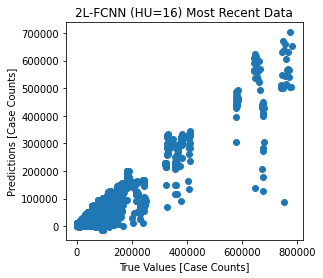

In [148]:
a = plt.axes(aspect='equal')
plt.scatter(y_recent, test_predictions)
plt.title('2L-FCNN (HU=16) Most Recent Data')
plt.xlabel('True Values [Case Counts]')
plt.ylabel('Predictions [Case Counts]')
plt.show()

In [151]:
corr_nnCustom, _ = pearsonr(y_recent, test_predictions)
print("Pearson Correlation Coefficient = ", corr_nnCustom) # Note: r = 0.5 - 1.0 means strong positive association
print("Mean Abolsute Error = ", mean_absolute_error(y_recent, test_predictions))

Pearson Correlation Coefficient =  0.9572112649478409
Mean Abolsute Error =  5800.219338747015


## Tune Best Model : https://www.tensorflow.org/tutorials/keras/keras_tuner (not enough time to do so)

## XGBoost

In [ ]:
!pip install shap
import shap 
import xgboost as xgb

     |████████████████████████████████| 371 kB 5.0 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Created wheel for shap: filename=shap-0.40.0-cp37-cp37m-linux_x86_64.whl size=509253 sha256=3a7e4d4a6a2d75b0869cf91318aee94fa0047d588c2f1b616cedfafe3b96ae93
  Stored in directory: /root/.cache/pip/wheels/ec/35/84/e304841ac4b910bc95fe9a6e5302eb2507b4333728851dcbfb
Successfully built shap


In [ ]:
xg_reg = xgb.XGBRegressor(objective ='reg:squarederror', colsample_bytree = 0.3, learning_rate = 0.1,
                max_depth = 5, alpha = 10, n_estimators = 10)

In [ ]:
X_train2_xgb = X_train2.set_axis(list('abcdefghijklmnopqr'), axis=1, inplace=False)
X_val_states_xgb = X_val_states.set_axis(list('abcdefghijklmnopqr'), axis=1, inplace=False)
xg_reg.fit(X_train2_xgb,y_train2)

xgb_preds = xg_reg.predict(X_val_states_xgb)

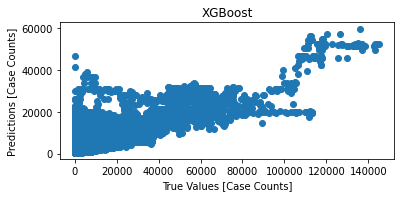

In [ ]:
a = plt.axes(aspect='equal')
plt.scatter(y_val_states, xgb_preds)
plt.title('XGBoost')
plt.xlabel('True Values [Case Counts]')
plt.ylabel('Predictions [Case Counts]')
plt.show()

In [ ]:
corr_xgb, _ = pearsonr(y_val_states, xgb_preds)
print("Pearson Correlation Coefficient = ", corr_xgb) # Note: r = 0.5 - 1.0 means strong positive association
print("Mean Abolsute Error = ", mean_absolute_error(y_val_states, xgb_preds))

Pearson Correlation Coefficient =  0.832711927497266
Mean Abolsute Error =  2036.2209402334


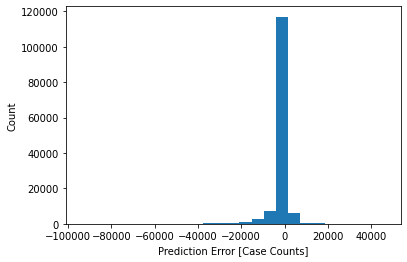

In [ ]:
error = xgb_preds - y_val_states
plt.hist(error, bins=25)
plt.xlabel('Prediction Error [Case Counts]')
_ = plt.ylabel('Count')

# Figures

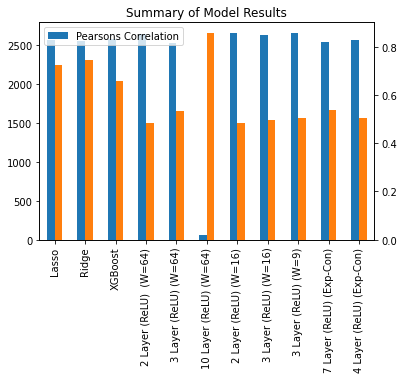

In [152]:
results = pd.read_csv('/content/drive/MyDrive/CS230_FINAL_PROJECT/model_results_updated.csv')
_ = results.plot( kind= 'bar' , secondary_y= 'Pearsons Correlation' , rot= 90, legend=False)
X = results['Model'].to_list()
X_axis = np.arange(len(X))
plt.xticks(X_axis, X)
plt.title('Summary of Model Results')
plt.legend(loc='upper left')
plt.savefig(FOLDERNAME + '/finalmodels', bbox_inches='tight')
plt.show()